In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv
/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv
/kaggle/input/child-mind-institute-problematic-internet-use/train.csv
/kaggle/input/child-mind-institute-problematic-internet-use/test.csv
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=00115b9f/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/id=001f3379/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0745c390/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=eaab7a96/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=8ec2cc63/part-0.parquet
/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=b2987a65/part-0.parquet
/kaggle/input/child-mind-institute-problematic-intern

In [2]:
data_dict = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv")
display(data_dict)
#data_dict.style.set_properties(**{'text-align': 'left'})

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [3]:
import os
import random
import numpy as np
import pandas as pd
import glob
from glob import glob
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import pyarrow as pa
import traceback
import uuid
from tqdm import tqdm
from collections import Counter
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option('display.float_format', lambda x: '%.6f' % x)
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
sns.set_theme(font="Arial", palette="deep")
sns.set(font="Arial")
%matplotlib inline
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib.cbook import boxplot_stats
import statsmodels.api as sm
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, f1_score, fowlkes_mallows_score, matthews_corrcoef, roc_auc_score, roc_curve, precision_recall_curve, make_scorer, classification_report

In [4]:
# Load both train and test datasets
train_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
test_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")

train_df.name = "train_data"
test_df.name = "test_data"

# List of dataframes
dfs = [(train_df.name, train_df), (test_df.name, test_df)]
for name, df in dfs:
    print(f"The {name} contains {df.shape[0]} rows and {df.shape[1]} columns.")
    display(df.sample(n=8, random_state=42))
    print()

The train_data contains 3960 rows and 82 columns.


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
149,0884aca8,Winter,12,0,Summer,60.000000,Winter,15.781633,56.000000,70.400000,NaN,58.000000,59.000000,112.000000,Winter,NaN,NaN,NaN,Winter,12.000000,0.000000,14.400000,2.000000,15.100000,2.000000,10.000000,1.000000,5.000000,0.000000,6.000000,0.000000,8.000000,0.000000,Winter,3.000000,9.565220,15.783400,1078.430000,1833.340000,11.230500,57.130500,12.808400,2.974970,13.269500,1.000000,26.970200,18.929800,47.565300,25.096500,38.200700,NaN,NaN,NaN,NaN,Spring,1.000000,5.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,29.000000,Spring,39.000000,55.000000,Winter,0.000000,0.000000
1025,3e3c242c,Spring,9,0,Fall,67.000000,Summer,13.620027,52.500000,53.400000,NaN,63.000000,96.000000,116.000000,Summer,3.000000,3.000000,0.000000,Summer,3.000000,0.000000,NaN,NaN,NaN,NaN,10.000000,1.000000,8.000000,1.000000,7.000000,0.000000,12.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,2.120000,Summer,0.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,Summer,26.000000,38.000000,Spring,0.000000,0.000000
1846,75311a3f,Winter,17,1,Summer,83.000000,Spring,21.318601,67.800000,139.400000,NaN,51.000000,57.000000,149.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,3.330000,NaN,NaN,Spring,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,Winter,36.000000,51.000000,Winter,2.000000,0.000000
720,2b3a6805,Spring,14,0,NaN,NaN,Spring,25.337695,66.000000,157.000000,36.000000,83.000000,67.000000,136.000000,NaN,NaN,NaN,NaN,Summer,20.000000,0.000000,56.800000,2.000000,79.200000,3.000000,7.000000,0.000000,7.000000,0.000000,6.000000,0.000000,12.000000,1.000000,Summer,2.000000,6.410270,25.340500,1651.360000,2642.180000,36.878500,118.155000,19.070700,6.269730,38.844900,2.000000,51.810700,29.465800,111.745000,56.748200,88.689200,Summer,2.630000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.000000,NaN
325,1314bc8c,Spring,12,0,NaN,NaN,Summer,14.861442,59.880000,75.800000,NaN,69.000000,74.000000,116.000000,NaN,NaN,NaN,NaN,Fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.050000,Spring,2.000000,1.000000,3.00000


The test_data contains 20 rows and 59 columns.


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.000000,Fall,16.877316,46.000000,50.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,7.000000,0.000000,6.000000,0.000000,6.000000,1.000000,Fall,2.000000,2.668550,16.879200,932.498000,1492.000000,8.255980,41.586200,13.817700,3.061430,9.213770,1.000000,24.434900,8.895360,38.917700,19.541300,32.690900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.000000
17,00d9913d,Fall,10,1,NaN,NaN,Fall,19.893157,55.000000,85.600000,30.000000,NaN,81.000000,NaN,NaN,NaN,NaN,NaN,Fall,5.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,1.000000
15,00c0cd71,Winter,7,0,Summer,51.000000,Spring,29.315775,54.000000,121.600000,NaN,80.000000,75.000000,99.000000,Spring,4.000000,5.000000,32.000000,Spring,6.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,12.000000,1.000000,15.000000,1.000000,12.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,35.000000,50.000000,Winter,2.000000
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.000000,46.000000,22.000000,75.000000,70.000000,122.000000,NaN,NaN,NaN,NaN,Fall,3.000000,0.000000,NaN,NaN,NaN,NaN,5.000000,0.000000,11.000000,1.000000,11.000000,1.000000,3.000000,0.000000,Winter,2.000000,2.579490,14.037100,936.656000,1498.650000,6.019930,42.029100,12.825400,1.211720,3.970850,1.000000,21.035200,14.974000,39.449700,15.410700,27.055200,NaN,NaN,Fall,2.340000,Fall,46.000000,64.000000,Summer,0.000000
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.000000
5,001f3379,Spring,13,1,Winter,50.000000,Summer,22.279952,59.500000,112.200000,NaN,60.000000,73.000000,102.000000,NaN,NaN,NaN,NaN,Summer,12.000000,0.000000,16.500000,2.000000,17.900000,2.000000,6.000000,0.000000,10.000000,1.000000,11.000000,1.000000,8.000000,0.000000,Summer,2.000000,4.330360,30.186500,1330.970000,1996.450000,30.212400,84.028500,16.687700,13.498800,67.971500,2.000000,32.914100,20.902000,79.698200,35.380400,63.126500,NaN,NaN,Spring,4.110000,Summer,40.000000,56.000000,Spring,0.000000
11,00abe655,Fall,11,0,Summer,66.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,1.100000,Winter,42.000000,59.000000,Fall,0.000000
3,00115b9f,Winter,9,0,Fall,71.000000,Summer,18.292347,56.000000,81.600000,NaN,60.000000,97.000000,117.000000,Summer,6.000000,9.000000,37.000000,Summer,18.000000,1.000000,NaN,NaN,NaN,NaN,5.000000,0.000000,7.000000,0.000000,7.000000,0.000000,7.000000,1.000000,Summer,3.000000,3.841910,18.294300,1131.430000,1923.440000,15.592500,62.775700,14.074000,4.220330,18.824300,2.000000,30.404100,16.779000,58.933800,26

In [5]:
def calculate_missing_percentage(df):
    """
    Calculate the percentage of missing values for each column in a DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame containing columns 'Column Name' and 'Missing Percentage',
                      sorted in descending order by missing percentage.
    """
    # Calculate missing percentage
    missing_percentage = (df.isna().sum() / len(df)) * 100
    
    # Convert to DataFrame
    missing_df = missing_percentage.reset_index()
    
    # Rename columns
    missing_df.columns = ['Column Name', 'Missing Percentage']
    
    # Sort by Missing Percentage
    missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False)

    display(missing_df)
    
    # Return the result
    return missing_df

In [6]:
for df in [train_df, test_df]:
    print(f"Missing values for {df.name}")
    globals()[f"missing_{df.name}"] = calculate_missing_percentage(df)
    print("--------"*20)

Missing values for train_data


,Column Name,Missing Percentage
51,PAQ_A-PAQ_A_Total,88.005051
50,PAQ_A-Season,88.005051
17,Fitness_Endurance-Time_Sec,81.313131
16,Fitness_Endurance-Time_Mins,81.313131
15,Fitness_Endurance-Max_Stage,81.237374
10,Physical-Waist_Circumference,77.323232
22,FGC-FGC_GSND_Zone,73.181818
24,FGC-FGC_GSD_Zone,73.156566
23,FGC-FGC_GSD,72.878788
21,FGC-FGC_GSND,72.878788


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Missing values for test_data


,Column Name,Missing Percentage
51,PAQ_A-PAQ_A_Total,95.000000
50,PAQ_A-Season,95.000000
17,Fitness_Endurance-Time_Sec,85.000000
16,Fitness_Endurance-Time_Mins,85.000000
15,Fitness_Endurance-Max_Stage,85.000000
14,Fitness_Endurance-Season,80.000000
21,FGC-FGC_GSND,75.000000
23,FGC-FGC_GSD,75.000000
24,FGC-FGC_GSD_Zone,75.000000
10,Physical-Waist_Circumference,75.000000


----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [7]:
# Find column differences between train and test
train_cols = set(train_df.columns)
test_cols = set(test_df.columns)

# Columns in train but not in test
cols_train_not_test = train_cols - test_cols

# Columns in test but not in train
cols_test_not_train = test_cols - train_cols

print("Columns in train but not test:\n", cols_train_not_test)
print("--------"*20)
print("Columns in test but not train:\n", cols_test_not_train)

Columns in train but not test:
 {'PCIAT-PCIAT_11', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_05', 'PCIAT-Season', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_02', 'sii', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_17'}
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Columns in test but not train:
 set()


In [8]:
# Columns to drop
pciat_columns = [
    'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04',
    'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08',
    'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12',
    'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16',
    'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20',
    'PCIAT-PCIAT_Total', 'PCIAT-Season'
]

# Drop PCIAT columns from the training data
train_df = train_df.drop(columns=pciat_columns)

# Find column differences between train and test
train_cols = set(train_df.columns)
test_cols = set(test_df.columns)

# Columns in train but not in test
cols_train_not_test = train_cols - test_cols

# Columns in test but not in train
cols_test_not_train = test_cols - train_cols

print("Columns in train but not test:", cols_train_not_test)
print("Columns in test but not train:", cols_test_not_train)

Columns in train but not test: {'sii'}
Columns in test but not train: set()


In [9]:
# Set threshold for missing data
threshold = 70.0

# Identify columns to drop
columns_to_drop_train = missing_train_data[missing_train_data['Missing Percentage'] > threshold]['Column Name'].tolist()
columns_to_drop_test = missing_test_data[missing_test_data['Missing Percentage'] > threshold]['Column Name'].tolist()

# Combine columns to drop (remove duplicates)
columns_to_drop = list(set(columns_to_drop_train) | set(columns_to_drop_test))
print(columns_to_drop)

['FGC-FGC_GSD', 'PAQ_A-Season', 'FGC-FGC_GSND_Zone', 'Fitness_Endurance-Time_Sec', 'Physical-Waist_Circumference', 'Fitness_Endurance-Season', 'Fitness_Endurance-Time_Mins', 'FGC-FGC_GSND', 'FGC-FGC_GSD_Zone', 'PAQ_A-PAQ_A_Total', 'Fitness_Endurance-Max_Stage']


In [10]:
# Drop columns from train and test datasets
train_df = train_df.drop(columns=columns_to_drop, errors='ignore')
test_df = test_df.drop(columns=columns_to_drop, errors='ignore')

In [11]:
train_columns = train_df.columns.tolist()
train_columns

['id',
 'Basic_Demos-Enroll_Season',
 'Basic_Demos-Age',
 'Basic_Demos-Sex',
 'CGAS-Season',
 'CGAS-CGAS_Score',
 'Physical-Season',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'FGC-Season',
 'FGC-FGC_CU',
 'FGC-FGC_CU_Zone',
 'FGC-FGC_PU',
 'FGC-FGC_PU_Zone',
 'FGC-FGC_SRL',
 'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_TL',
 'FGC-FGC_TL_Zone',
 'BIA-Season',
 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_BMC',
 'BIA-BIA_BMI',
 'BIA-BIA_BMR',
 'BIA-BIA_DEE',
 'BIA-BIA_ECW',
 'BIA-BIA_FFM',
 'BIA-BIA_FFMI',
 'BIA-BIA_FMI',
 'BIA-BIA_Fat',
 'BIA-BIA_Frame_num',
 'BIA-BIA_ICW',
 'BIA-BIA_LDM',
 'BIA-BIA_LST',
 'BIA-BIA_SMM',
 'BIA-BIA_TBW',
 'PAQ_C-Season',
 'PAQ_C-PAQ_C_Total',
 'SDS-Season',
 'SDS-SDS_Total_Raw',
 'SDS-SDS_Total_T',
 'PreInt_EduHx-Season',
 'PreInt_EduHx-computerinternet_hoursday',
 'sii']

In [12]:
from sklearn.impute import SimpleImputer

# Separate numerical and categorical columns
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.drop('sii', errors='ignore')
cat_cols = train_df.select_dtypes(include=['object']).columns

# Impute numerical columns with mean
num_imputer = SimpleImputer(strategy='median')
train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])
test_df[num_cols] = num_imputer.transform(test_df[num_cols])

# Impute categorical columns with most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])
test_df[cat_cols] = cat_imputer.transform(test_df[cat_cols])

# Verify missing values
print("Remaining missing values in train:", train_df.isnull().sum().sum())
print("Remaining missing values in test:", test_df.isnull().sum().sum())

Remaining missing values in train: 1224
Remaining missing values in test: 0


In [13]:
# Define the directory path
parquet_dir = "/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet"

# Use glob to find all .parquet files recursively
parquet_files = glob(os.path.join(parquet_dir, '**', '*.parquet'), recursive=True)

print(f"Total Parquet files found: {len(parquet_files)}")

Total Parquet files found: 996


In [14]:
# Count total records
total_records = 0
for file in parquet_files:
    metadata = pq.ParquetFile(file).metadata
    total_records += metadata.num_rows
print(f"Total number of records: {total_records}")

Total number of records: 314569149


In [15]:
# Define the directory path
parquet_test_dir = "/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet"

# Use glob to find all .parquet files recursively
parquet_test_files = glob(os.path.join(parquet_test_dir, '**', '*.parquet'), recursive=True)

print(f"Total Parquet files found: {len(parquet_test_files)}")

Total Parquet files found: 2


In [16]:
# Count total records
total_records = 0
for file in parquet_test_files:
    metadata = pq.ParquetFile(file).metadata
    total_records += metadata.num_rows
print(f"Total number of records: {total_records}")

Total number of records: 439726


In [17]:
# Missing values in parquet files
def calculate_missing_values(parquet_file_list):
    """
    Calculate the total missing values across multiple Parquet files in batches.
    
    Args:
        parquet_file_list (list): List of Parquet file paths.
        
    Returns:
        pd.DataFrame: DataFrame with column names and their total missing counts.
    """
    missing_counts = {}

    # Loop over each Parquet file
    for file in parquet_file_list:
        table = pq.ParquetFile(file)
        
        # Process data in batches for memory efficiency
        for batch in table.iter_batches():
            df_chunk = batch.to_pandas()  # Convert to Pandas DataFrame
            
            # Compute missing values for the chunk
            chunk_missing = df_chunk.isnull().sum()
            
            # Update missing counts
            for col, count in chunk_missing.items():
                missing_counts[col] = missing_counts.get(col, 0) + count

    # Convert the dictionary to a DataFrame for visualization
    missing_counts_df = pd.DataFrame(
        missing_counts.items(), columns=['Column', 'Missing Count']
    ).sort_values(by='Missing Count', ascending=False)

    return missing_counts_df
            
all_parquet_files = parquet_files + parquet_test_files
missing_counts_df = calculate_missing_values(all_parquet_files)
display(missing_counts_df)

,Column,Missing Count
0,step,0
1,X,0
2,Y,0
3,Z,0
4,enmo,0
5,anglez,0
6,non-wear_flag,0
7,light,0
8,battery_voltage,0
9,time_of_day,0


In [18]:
def calculate_non_wear_flag_distribution(parquet_files):
    """
    Calculate the percentage distribution of non-wear_flag values (1, 0, and others).

    Parameters:
        parquet_files (list): List of Parquet file paths.

    Returns:
        pd.DataFrame: A DataFrame containing the distribution of wear, non-wear, and other flag rates.
    """
    # Initialize a list to store results
    file_results = []

    # Process each file
    for file in parquet_files:
        try:
            # Extract the ID from the file name
            file_id = os.path.basename(os.path.dirname(file)).split('id=')[-1]
            
            # Read the Parquet file
            table = pq.ParquetFile(file)
            total_rows_file = 0
            count_flag_1_file = 0
            count_flag_0_file = 0
            count_flag_other_file = 0

            # Process in row group chunks
            for batch in table.iter_batches():
                # Convert batch to DataFrame
                df_chunk = batch.to_pandas()

                # Update total row count for the file
                total_rows_file += len(df_chunk)
                
                # Update counts for specific conditions
                count_flag_1_file += (df_chunk['non-wear_flag'] == 1).sum()
                count_flag_0_file += (df_chunk['non-wear_flag'] == 0).sum()
                count_flag_other_file += ((df_chunk['non-wear_flag'] != 1) & (df_chunk['non-wear_flag'] != 0)).sum()

            # Calculate percentages for the current file
            percent_flag_1_file = (count_flag_1_file / total_rows_file) if total_rows_file else 0
            percent_flag_0_file = (count_flag_0_file / total_rows_file) if total_rows_file else 0
            percent_flag_other_file = (count_flag_other_file / total_rows_file) if total_rows_file else 0

            # Append results to the list
            file_results.append({
                'File ID': file_id,
                'Total Rows': total_rows_file,
                'wear_rate': percent_flag_0_file,
                'non_wear_rate': percent_flag_1_file,
                'non-wear_flag != 1 and != 0 (%)': percent_flag_other_file
            })

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    # Convert the results to a DataFrame
    file_results_df = pd.DataFrame(file_results)
    return file_results_df

In [19]:
# For parquet_files
parquet_files_results = calculate_non_wear_flag_distribution(parquet_files)
display(parquet_files_results.head(10))

,File ID,Total Rows,wear_rate,non_wear_rate,non-wear_flag != 1 and != 0 (%)
0,0745c390,50458,1.000000,0.000000,0.000000
1,eaab7a96,340584,0.950864,0.043881,0.005256
2,8ec2cc63,40003,1.000000,0.000000,0.000000
3,b2987a65,223915,1.000000,0.000000,0.000000
4,7b8842c3,15420,1.000000,0.000000,0.000000
5,b120a337,387432,0.819772,0.167291,0.012936
6,5f9dddb4,18204,0.950615,0.029719,0.019666
7,2c3b09db,96266,1.000000,0.000000,0.000000
8,3ab539f0,260128,1.000000,0.000000,0.000000
9,9f9be55c,395604,0.929035,0.065535,0.005430


In [20]:
# For parquet_test_files
parquet_test_files_results = calculate_non_wear_flag_distribution(parquet_test_files)
display(parquet_test_files_results.head(10))

,File ID,Total Rows,wear_rate,non_wear_rate,non-wear_flag != 1 and != 0 (%)
0,00115b9f,43330,1.000000,0.000000,0.000000
1,001f3379,396396,0.326229,0.637645,0.036125


In [21]:
# Merge datasets on 'File ID'
train_df = train_df.merge(parquet_files_results[['File ID', 'Total Rows', 'wear_rate', 'non_wear_rate']], left_on='id', right_on='File ID', how='left')
test_df = test_df.merge(parquet_test_files_results[['File ID', 'Total Rows', 'wear_rate', 'non_wear_rate']], left_on='id', right_on='File ID', how='left')

train_df['Actigraphy Available'] = train_df['File ID'].notnull().map({True: 1, False: 0})
test_df['Actigraphy Available'] = test_df['File ID'].notnull().map({True: 1, False: 0})

train_df.drop(columns="File ID", inplace=True)
test_df.drop(columns="File ID", inplace=True)

In [22]:
train_df.groupby("Actigraphy Available").describe()

Basic_Demos-Age                                       \
                               count      mean      std      min      25%   
Actigraphy Available                                                        
0                        2964.000000 10.475709 3.611175 5.000000 8.000000   
1                         996.000000 10.308233 3.462414 5.000000 8.000000   

                                                   Basic_Demos-Sex           \
                           50%       75%       max           count     mean   
Actigraphy Available                                                          
0                    10.000000 13.000000 22.000000     2964.000000 0.381579   
1                    10.000000 12.000000 21.000000      996.000000 0.346386   

                                                                            \
                          std      min      25%      50%      75%      max   
Actigraphy Available                                                         
0                    0.485856 0.000000 0.000000 0.000000 1.000000 1.000000   
1                    0.476057 0.000000 0.000000 0.000000 1.000000 1.000000   

                     CGAS-CGAS_Score                                          \
                               count      mean       std       min       25%   
Actigraphy Available                                                           
0                        2964.000000 65.555668 19.096181 25.000000 65.000000   
1                         996.000000 64.451807 11.286613 31.000000 58.000000   

                                                    Physical-BMI            \
                           50%       75%        max        count      mean   
Actigraphy Available                                                         
0                    65.000000 65.000000 999.000000  2964.000000 18.909911   
1                    64.500000 71.000000  95.000000   996.000000 19.274757   

                                                                      \
                          std      min       25%       50%       75%   
Actigraphy Available                                                   
0                    4.318970 0.000000 16.789213 17.937682 19.707960   
1                    5.015364 0.000000 15.891780 17.936668 21.461824   

                               Physical-Height                               \
                           max           count      mean      std       min   
Actigraphy Available                                                          
0                    59.132048     2964.000000 55.593006 6.215606 33.000000   
1                    45.306026      996.000000 56.112480 7.434128 39.000000   

                                                             Physical-Weight  \
                           25%       50%       75%       max           count   
Actigraphy Available                                                           
0                    52.000000 55.000000 58.500000 78.500000     2964.000000   
1                    50.500000 55.000000 62.000000 78.000000      996.000000   

                                                                       \
                          mean       std      min       25%       50%   
Actigraphy Available                                                    
0                    84.874015 38.182376 0.000000 64.000000 77.000000   
1                    90.747189 43.261970 0.000000 58.800000 78.000000   

                                           Physical-Diastolic_BP            \
                            75%        max                 count      mean   
Actigraphy Available                                                         
0                     96.000000 306.400000           2964.000000 68.957152   
1                    113.100000 315.000000            996.000000 70.042169   

                                                                        \
                           std       min       25%       50%       

**Demographics (Age and Sex)**
- The age distribution is similar between the two groups, with a slight difference in the mean (10.48 for No, 10.31 for Yes).
- Slightly more males (mean Sex = 1) in the No actigraphy group compared to the Yes group. However, this difference is minor.

**CGAS-CGAS_Score (Global Assessment Scale)**
- Participants with actigraphy (Yes) have slightly lower mean scores (64.43) compared to those without (66.12), suggesting that participants with slightly poorer functioning might be more likely to receive actigraphy monitoring.

**Physical Measurements**

- Both groups show similar distributions for BMI, Height, and Weight, with only minor differences in means and ranges. Participants with actigraphy have slightly narrower ranges for some measures (e.g., BMI max is 45.31 vs. 59.13).
- Mean and quartile values for Diastolic and Systolic Blood Pressure are almost identical between groups.
- Waist Circumference Data is sparse, with only 47 records in the actigraphy group, making comparisons unreliable.

**Fitness Endurance**
- Participants with actigraphy (Yes) show slightly better endurance (e.g., Max_Stage mean is 5.03 vs. 4.96), though the difference is small.

**Behavioral Features**
- Internet usage habits are similar between groups, with mean usage ~1 hour/day.

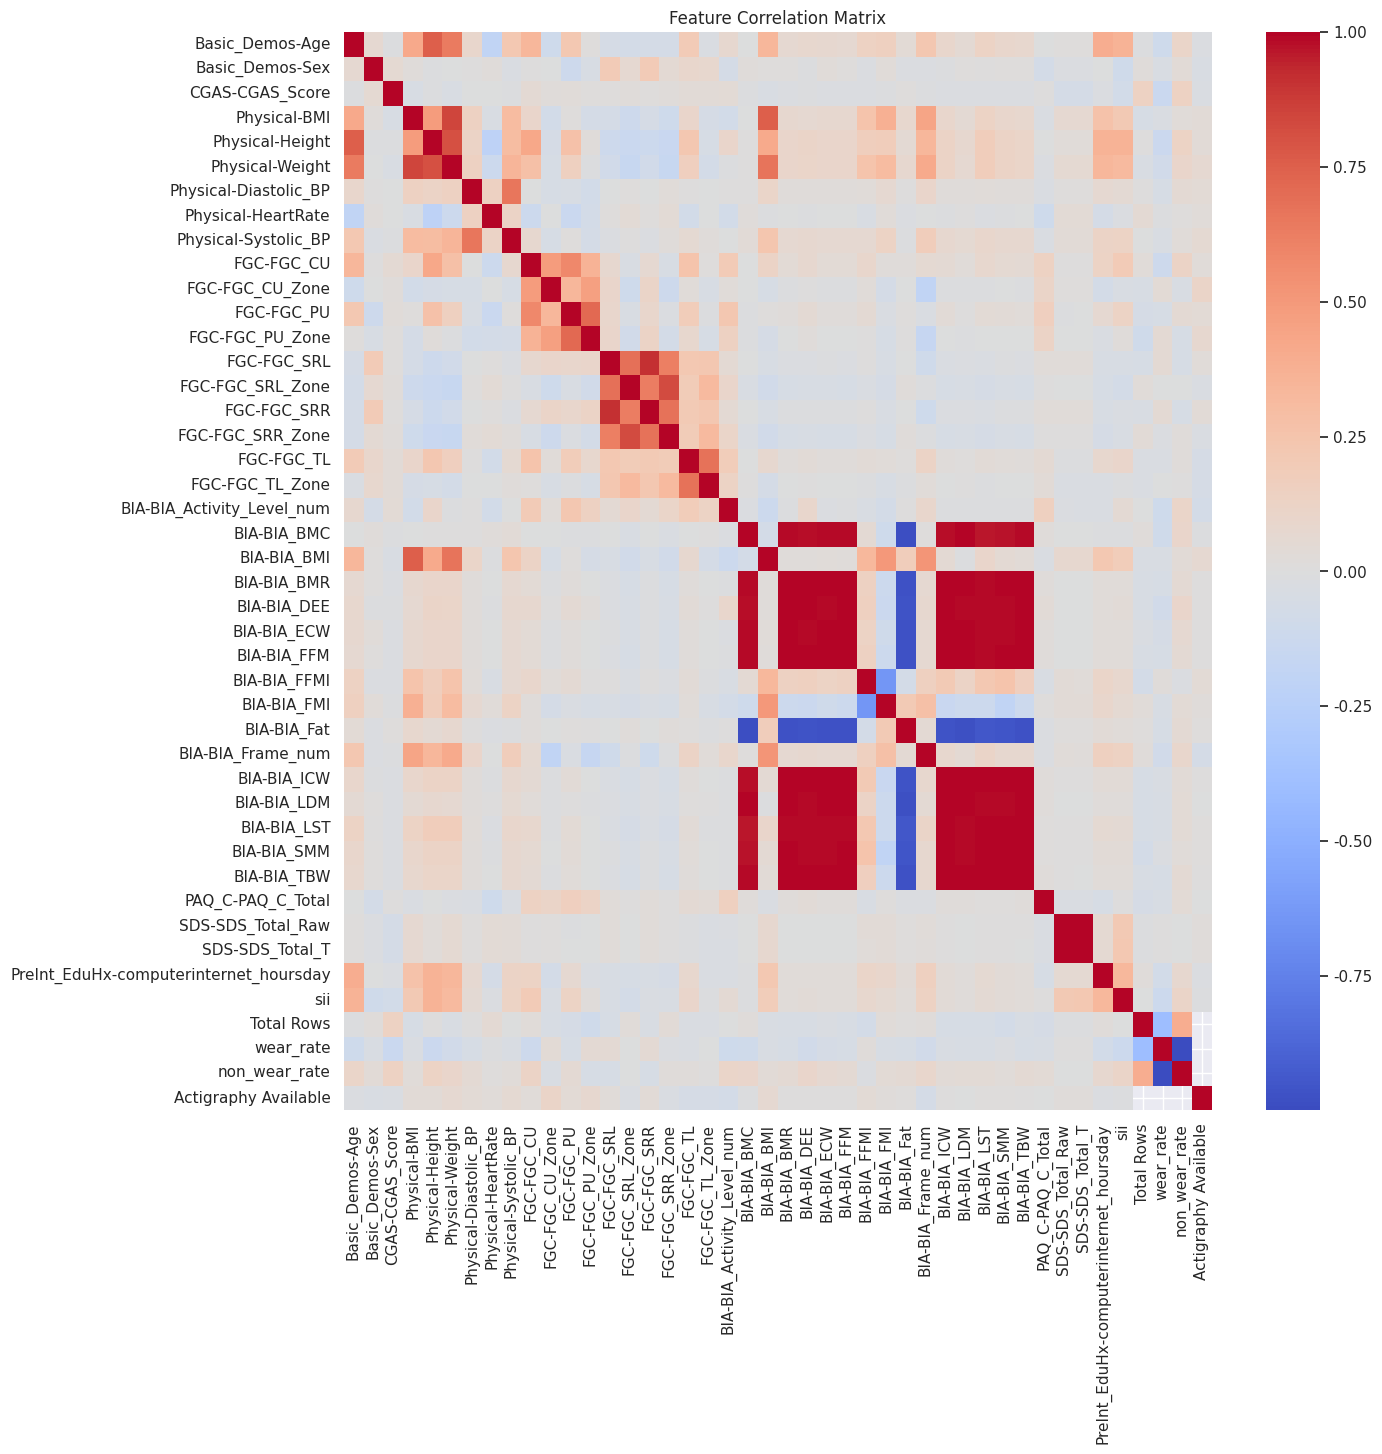

In [23]:
# Compute correlation matrix
corr_matrix = train_df.corr(numeric_only=True)

# Visualize with a heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=False,cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [24]:
# Function to drop highly correlated features
def drop_highly_correlated_features(df, threshold=0.85):
    """
    Drops highly correlated features in a DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing features.
        threshold (float): Correlation threshold. Features with correlation > threshold are dropped.

    Returns:
        pd.DataFrame: DataFrame with reduced features.
        list: List of dropped features.
    """
    # Compute correlation matrix
    corr_matrix = df.corr(numeric_only=True).abs()

    # Upper triangle of the correlation matrix (to avoid duplicate pairs)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify features to drop
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop the features
    reduced_df = df.drop(columns=to_drop)

    print(f"Features to drop ({len(to_drop)}): {to_drop}")
    return reduced_df, to_drop

In [25]:
train_df1, dropped_features1 = drop_highly_correlated_features(train_df, threshold=0.85)
print(f"Original features: {train_df.shape[1]}")
print(f"Reduced features: {train_df1.shape[1]}")
print(f"Dropped features: {dropped_features1}")

test_df1 = test_df.drop(columns=dropped_features1)

Features to drop (13): ['FGC-FGC_SRR', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'SDS-SDS_Total_T', 'non_wear_rate']
Original features: 53
Reduced features: 40
Dropped features: ['FGC-FGC_SRR', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'SDS-SDS_Total_T', 'non_wear_rate']


In [26]:
# Columns to one-hot encode
season_columns = [col for col in train_df1.columns.tolist() if 'Season' in col]

# Concatenate train and test to ensure consistent encoding
combined_df = pd.concat([train_df1, test_df1], keys=['train', 'test'])

# Perform one-hot encoding
combined_encoded = pd.get_dummies(combined_df, columns=season_columns, drop_first=False)

# Split back into train and test sets
train_encoded = combined_encoded.loc['train'].reset_index(drop=True)
test_encoded = combined_encoded.loc['test'].reset_index(drop=True)

In [27]:
proc_columns = train_encoded.columns.tolist()
proc_columns

['id',
 'Basic_Demos-Age',
 'Basic_Demos-Sex',
 'CGAS-CGAS_Score',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'FGC-FGC_CU',
 'FGC-FGC_CU_Zone',
 'FGC-FGC_PU',
 'FGC-FGC_PU_Zone',
 'FGC-FGC_SRL',
 'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_TL',
 'FGC-FGC_TL_Zone',
 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_BMC',
 'BIA-BIA_BMI',
 'BIA-BIA_FFMI',
 'BIA-BIA_FMI',
 'BIA-BIA_Frame_num',
 'PAQ_C-PAQ_C_Total',
 'SDS-SDS_Total_Raw',
 'PreInt_EduHx-computerinternet_hoursday',
 'sii',
 'Total Rows',
 'wear_rate',
 'Actigraphy Available',
 'Basic_Demos-Enroll_Season_Fall',
 'Basic_Demos-Enroll_Season_Spring',
 'Basic_Demos-Enroll_Season_Summer',
 'Basic_Demos-Enroll_Season_Winter',
 'CGAS-Season_Fall',
 'CGAS-Season_Spring',
 'CGAS-Season_Summer',
 'CGAS-Season_Winter',
 'Physical-Season_Fall',
 'Physical-Season_Spring',
 'Physical-Season_Summer',
 'Physical-Season_Winter',
 'FGC-Season_Fall',
 'FGC-Seas

In [28]:
def extract_aggregated_features(parquet_files, output_file=None):
    """
    Extract aggregated features from Parquet files and save them to a CSV (optional).

    Parameters:
        parquet_files (list): List of Parquet file paths.
        output_file (str, optional): File path to save the aggregated features as CSV.

    Returns:
        pd.DataFrame: A DataFrame containing aggregated features for all files.
    """
    # Initialize an empty list to collect results
    aggregated_features_list = []

    # Process each Parquet file
    for file in tqdm(parquet_files, desc="Processing Parquet Files"):
        try:
            # Load data from the file
            df = pd.read_parquet(file)

            # Convert 'time_of_day' to seconds for cyclical encoding
            df['time_of_day'] = pd.to_timedelta(df['time_of_day'], unit='ns')
            df['time_of_day_seconds'] = df['time_of_day'].dt.total_seconds()

            # Cyclical encoding for time_of_day
            df['time_of_day_sin'] = np.sin(2 * np.pi * df['time_of_day_seconds'] / (24 * 60 * 60))
            df['time_of_day_cos'] = np.cos(2 * np.pi * df['time_of_day_seconds'] / (24 * 60 * 60))

            # Cyclical encoding for weekday
            df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
            df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

            # Calculate the combined magnitude of accelerations
            df['magnitude'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)

            # Extract participant ID
            participant_id = os.path.basename(os.path.dirname(file)).split('id=')[-1]

            # Aggregate features
            aggregated_features = {
                'id': participant_id,
                'time_of_day_sin_mean': df['time_of_day_sin'].mean(),
                'time_of_day_sin_std': df['time_of_day_sin'].std(),
                'time_of_day_cos_mean': df['time_of_day_cos'].mean(),
                'time_of_day_cos_std': df['time_of_day_cos'].std(),
                'weekday_sin_mean': df['weekday_sin'].mean(),
                'weekday_sin_std': df['weekday_sin'].std(),
                'weekday_cos_mean': df['weekday_cos'].mean(),
                'weekday_cos_std': df['weekday_cos'].std(),
                'magnitude_mean': df['magnitude'].mean(),
                'magnitude_median': df['magnitude'].median(),
                'magnitude_std': df['magnitude'].std(),
                'magnitude_min': df['magnitude'].min(),
                'magnitude_max': df['magnitude'].max(),
                'enmo_mean': df['enmo'].mean(),
                'enmo_median': df['enmo'].median(),
                'enmo_std': df['enmo'].std(),
                'enmo_min': df['enmo'].min(),
                'enmo_max': df['enmo'].max(),
                'anglez_mean': df['anglez'].mean(),
                'anglez_median': df['anglez'].median(),
                'anglez_std': df['anglez'].std(),
                'anglez_min': df['anglez'].min(),
                'anglez_max': df['anglez'].max(),
                'light_mean': df['light'].mean(),
                'light_median': df['light'].median(),
                'light_std': df['light'].std(),
                'light_min': df['light'].min(),
                'light_max': df['light'].max(),
                'X_mean': df['X'].mean(),
                'X_median': df['X'].median(),
                'X_std': df['X'].std(),
                'X_min': df['X'].min(),
                'X_max': df['X'].max(),
                'Y_mean': df['Y'].mean(),
                'Y_median': df['Y'].median(),
                'Y_std': df['Y'].std(),
                'Y_min': df['Y'].min(),
                'Y_max': df['Y'].max(),
                'Z_mean': df['Z'].mean(),
                'Z_median': df['Z'].median(),
                'Z_std': df['Z'].std(),
                'Z_min': df['Z'].min(),
                'Z_max': df['Z'].max(),
                'time_bin_nunique': df['time_of_day_seconds'].div(15 * 60).astype(int).nunique(),
            }

            aggregated_features_list.append(aggregated_features)
        
        except Exception as e:
            print(f"Error processing file {file}: {e}")

    # Convert the aggregated features list into a DataFrame
    aggregated_features_df = pd.DataFrame(aggregated_features_list)

    # Save the aggregated features to disk if requested
    if output_file:
        aggregated_features_df.to_csv(output_file, index=False)
        print(f"Aggregated features saved to {output_file}")

    return aggregated_features_df

In [29]:
parquet_files_aggregated = extract_aggregated_features(parquet_files, "train_aggregated_features.csv")
display(parquet_files_aggregated.head())

Processing Parquet Files: 100%|██████████| 996/996 [01:57<00:00,  8.48it/s]


Aggregated features saved to train_aggregated_features.csv


,id,time_of_day_sin_mean,time_of_day_sin_std,time_of_day_cos_mean,time_of_day_cos_std,weekday_sin_mean,weekday_sin_std,weekday_cos_mean,weekday_cos_std,magnitude_mean,magnitude_median,magnitude_std,magnitude_min,magnitude_max,enmo_mean,enmo_median,enmo_std,enmo_min,enmo_max,anglez_mean,anglez_median,anglez_std,anglez_min,anglez_max,light_mean,light_median,light_std,light_min,light_max,X_mean,X_median,X_std,X_min,X_max,Y_mean,Y_median,Y_std,Y_min,Y_max,Z_mean,Z_median,Z_std,Z_min,Z_max,time_bin_nunique
0,0745c390,-0.388318,0.587697,-0.185099,0.685256,-0.278215,0.653893,0.002042,0.703587,0.974322,0.996592,0.091011,0.090195,3.751890,0.045252,0.019257,0.132576,0.000000,5.314874,-7.805897,-6.358004,34.917873,-89.987045,89.422226,46.009533,8.230734,205.862213,0.000000,2626.199951,-0.054638,0.015846,0.633126,-1.812031,1.850391,-0.163923,-0.141810,0.513286,-2.631380,3.580182,-0.114302,-0.104193,0.500372,-1.798073,1.738203,96
1,eaab7a96,-0.006816,0.708263,0.010798,0.705835,0.029144,0.713511,-0.051429,0.698148,0.969635,0.993656,0.088858,0.059753,3.486588,0.028960,0.005257,0.096825,0.000000,3.966906,-6.065619,-13.454103,44.034721,-89.654587,89.080330,56.437958,10.050480,206.625092,0.000000,2628.199951,0.113277,0.094074,0.507897,-1.807955,1.928769,0.093139,0.068143,0.541129,-2.887664,3.234613,-0.106038,-0.228500,0.603787,-1.004992,2.475326,96
2,8ec2cc63,-0.099679,0.724064,-0.240576,0.638704,0.086013,0.592371,-0.563242,0.569626,0.953107,0.981113,0.115850,0.108904,3.718441,0.056544,0.018467,0.140594,0.000000,5.066334,-11.934993,-11.570901,27.367514,-89.540176,86.987267,77.305130,7.863636,274.848145,0.000000,2618.199951,-0.499738,-0.644505,0.454021,-1.903281,1.021510,0.046381,0.088542,0.510668,-3.150104,1.016589,-0.181152,-0.191693,0.412588,-1.020313,1.746797,96
3,b2987a65,-0.185620,0.686153,-0.319387,0.626686,-0.060419,0.691012,0.080136,0.715846,0.941815,0.987492,0.119508,0.034666,6.397051,0.053544,0.027653,0.103401,0.000000,6.134459,-12.847143,-15.000056,32.552841,-89.968369,89.976074,9.369678,2.340206,54.104408,0.000000,2502.000000,0.007430,0.022344,0.586100,-1.684624,5.908000,0.007583,0.009674,0.542189,-2.405738,2.083693,-0.196510,-0.245181,0.474437,-1.023798,1.269051,96
4,7b8842c3,-0.475796,0.582771,0.136891,0.644443,0.194635,0.560712,0.053911,0.803041,0.972541,0.991824,0.089153,0.040806,3.383626,0.040399,0.024135,0.090201,0.000000,2.774382,-11.009835,-13.665493,47.933723,-89.770241,89.300034,5.049157,2.897436,15.590773,0.000000,1046.800049,0.086653,0.053034,0.509845,-1.675859,3.231563,-0.115162,-0.087422,0.494897,-1.071042,1.033620,-0.138969,-0.225430,0.639449,-1.012266,1.071875,90


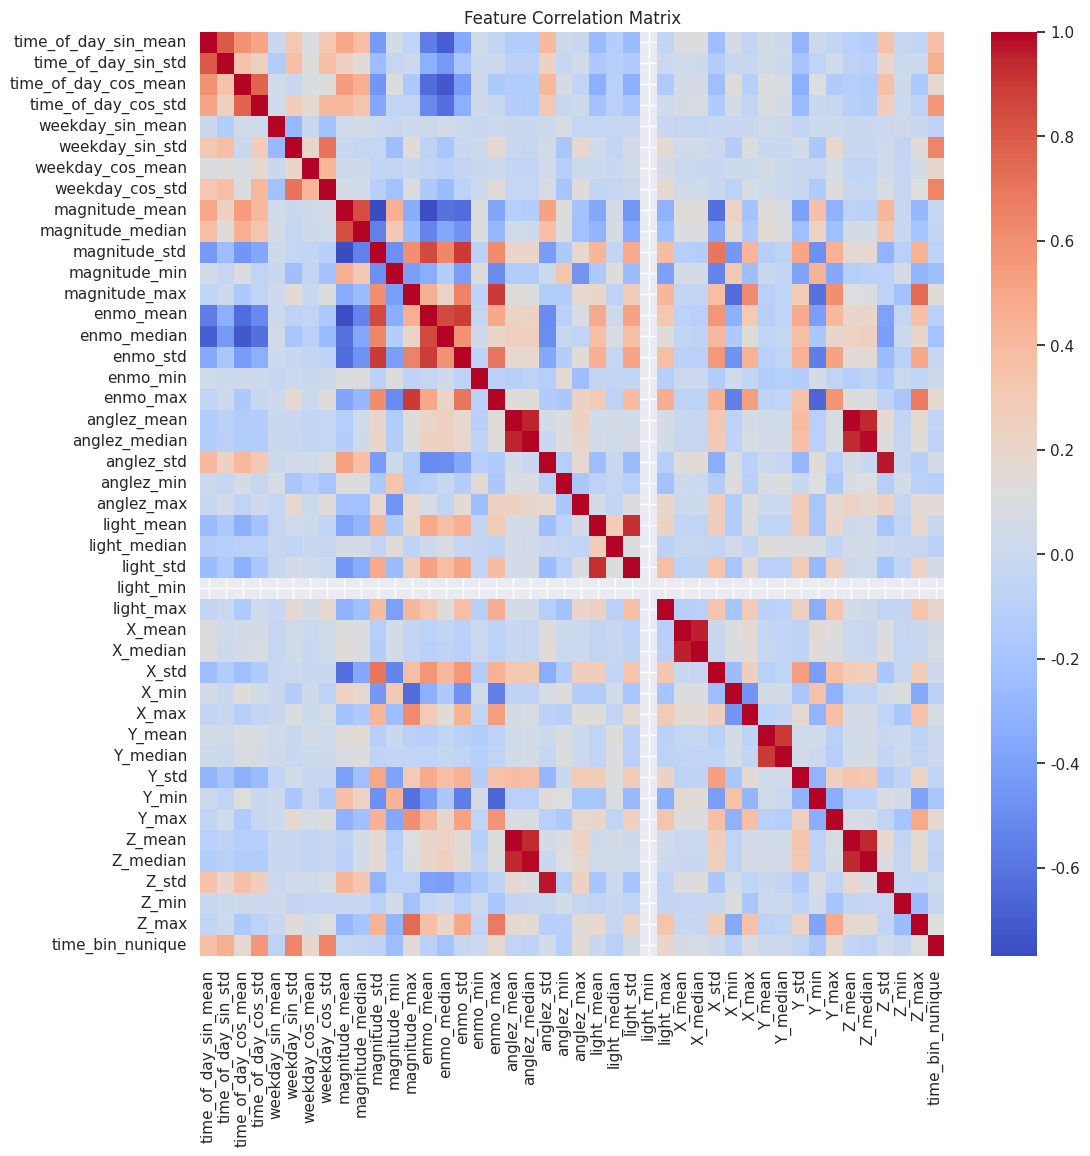

In [30]:
# Compute correlation matrix
corr_matrix = parquet_files_aggregated.drop(columns="id").corr(numeric_only=True)

# Visualize with a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [31]:
parquet_test_files_aggregated = extract_aggregated_features(parquet_test_files, "test_aggregated_features.csv")
display(parquet_test_files_aggregated.head())

Processing Parquet Files: 100%|██████████| 2/2 [00:00<00:00, 12.10it/s]

Aggregated features saved to test_aggregated_features.csv


,id,time_of_day_sin_mean,time_of_day_sin_std,time_of_day_cos_mean,time_of_day_cos_std,weekday_sin_mean,weekday_sin_std,weekday_cos_mean,weekday_cos_std,magnitude_mean,magnitude_median,magnitude_std,magnitude_min,magnitude_max,enmo_mean,enmo_median,enmo_std,enmo_min,enmo_max,anglez_mean,anglez_median,anglez_std,anglez_min,anglez_max,light_mean,light_median,light_std,light_min,light_max,X_mean,X_median,X_std,X_min,X_max,Y_mean,Y_median,Y_std,Y_min,Y_max,Z_mean,Z_median,Z_std,Z_min,Z_max,time_bin_nunique
0,00115b9f,-0.270075,0.693359,-0.218046,0.631497,-0.177009,0.683272,0.051061,0.706557,0.958392,0.989685,0.107638,0.065540,2.982514,0.047388,0.023637,0.106351,0.000000,4.004276,-10.580416,-15.086617,42.947170,-89.833092,89.751656,42.296310,6.926828,208.168976,0.000000,2633.250000,-0.316384,-0.366849,0.453665,-1.746094,1.507865,0.016009,0.024974,0.502702,-2.905339,1.666354,-0.167890,-0.245378,0.585710,-1.048372,1.546979,96
1,001f3379,-0.001029,0.707735,0.002407,0.706475,0.033940,0.700168,-0.060384,0.710612,1.001227,1.009539,0.039216,0.049338,2.171842,0.011926,0.009831,0.024331,0.000000,2.952888,-55.630768,-86.119919,50.303635,-88.761833,89.476036,16.771982,0.879005,95.327438,0.000000,2597.800049,-0.004272,-0.020622,0.351545,-1.038711,1.034351,0.016859,-0.028179,0.303812,-1.522690,1.946303,-0.631731,-1.007728,0.623476,-1.018787,1.146284,96


In [32]:
parquet_files_aggregated2, dropped_features2 = drop_highly_correlated_features(parquet_files_aggregated, threshold=0.85)
print(f"Original features: {parquet_files_aggregated.shape[1]}")
print(f"Reduced features: {parquet_files_aggregated2.shape[1]}")
print(f"Dropped features: {dropped_features2}")

parquet_test_files_aggregated2 = parquet_test_files_aggregated.drop(columns=dropped_features2)

Features to drop (11): ['enmo_mean', 'enmo_median', 'enmo_std', 'enmo_max', 'anglez_median', 'light_std', 'X_median', 'Y_median', 'Z_mean', 'Z_median', 'Z_std']
Original features: 45
Reduced features: 34
Dropped features: ['enmo_mean', 'enmo_median', 'enmo_std', 'enmo_max', 'anglez_median', 'light_std', 'X_median', 'Y_median', 'Z_mean', 'Z_median', 'Z_std']


In [33]:
# Check for missing actigraphy features after merging
train_act = train_encoded[train_encoded['Actigraphy Available']==1]
train_no_act = train_encoded[train_encoded['Actigraphy Available']==0]

test_act = test_encoded[test_encoded['Actigraphy Available']==1]
test_no_act = test_encoded[test_encoded['Actigraphy Available']==0]

In [34]:
# Merge with aggregated actigraphy features
train_act = train_act.merge(parquet_files_aggregated2, on='id', how='left')
test_act = test_act.merge(parquet_test_files_aggregated2, on='id', how='left')

print("Train with actigraphy:", train_act.shape)
print("Train without actigraphy:", train_no_act.shape)
print("Test with actigraphy:", test_act.shape)
print("Test without actigraphy:", test_no_act.shape)

Train with actigraphy: (996, 97)
Train without actigraphy: (2964, 64)
Test with actigraphy: (2, 97)
Test without actigraphy: (18, 64)


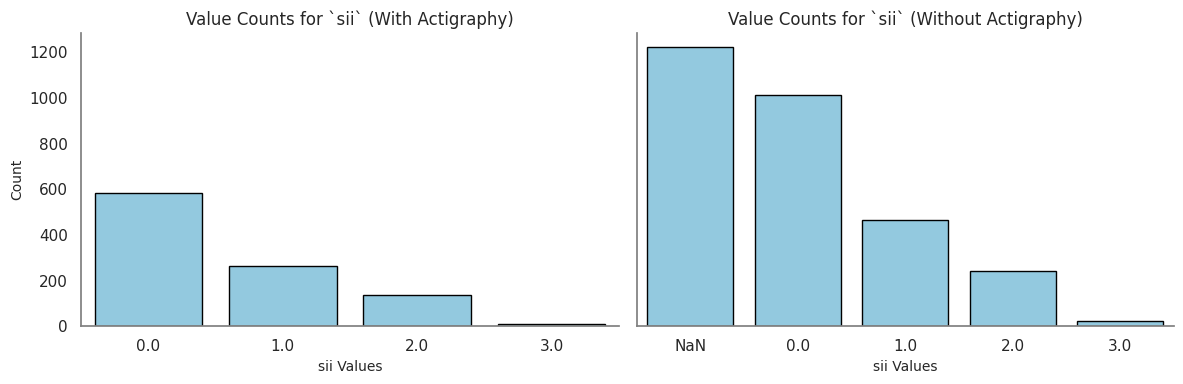

In [35]:
# Convert NaN to a string 'NaN' to include it in value counts
train_act['sii_plot'] = train_act['sii'].fillna('NaN')
train_no_act['sii_plot'] = train_no_act['sii'].fillna('NaN')

# Count `sii` including NaN for both datasets
sii_counts_act = train_act['sii_plot'].value_counts().reset_index()
sii_counts_no_act = train_no_act['sii_plot'].value_counts().reset_index()

# Rename columns for better compatibility
sii_counts_act.columns = ['sii', 'count']
sii_counts_no_act.columns = ['sii', 'count']

# Set Seaborn style for a clean white background
sns.set_style("white")

# Create the side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot for train_act
sns.barplot(x='sii', y='count', data=sii_counts_act, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Value Counts for `sii` (With Actigraphy)', fontsize=12)
axes[0].set_xlabel('sii Values', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)

# Remove unwanted spines and adjust appearance
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_color("grey")
axes[0].spines['bottom'].set_color("grey")

# Plot for train_no_act
sns.barplot(x='sii', y='count', data=sii_counts_no_act, ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Value Counts for `sii` (Without Actigraphy)', fontsize=12)
axes[1].set_xlabel('sii Values', fontsize=10)
axes[1].set_ylabel('')  # No Y-axis label to avoid duplication

# Remove unwanted spines and adjust appearance
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_color("grey")
axes[1].spines['bottom'].set_color("grey")

# Adjust layout and show
plt.tight_layout()
plt.show()

In [36]:
def custom_qwk(y_true, y_pred):
    return quadratic_weighted_kappa(y_true.astype(int), y_pred.astype(int))

In [37]:
from sklearn.metrics import make_scorer

import numpy as np

def quadratic_weighted_kappa(y_true, y_pred):
    """
    Compute the Quadratic Weighted Kappa (QWK) score.

    Parameters:
    - y_true: 1D array-like, true labels (integer values)
    - y_pred: 1D array-like, predicted labels (integer values)

    Returns:
    - kappa: Quadratic Weighted Kappa score, a float between -1 and 1.
    """
    # Ensure inputs are numpy arrays and integers
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)

    # Determine N (number of unique labels)
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    N = len(unique_labels)

    # Construct the observed matrix (O)
    O = np.zeros((N, N), dtype=float)  # N x N histogram matrix
    for actual, predicted in zip(y_true, y_pred):
        O[actual, predicted] += 1  # Increment the cell corresponding to (actual, predicted)

    # Construct the weight matrix (W)
    W = np.zeros((N, N), dtype=float)  # Weight matrix
    for i in range(N):
        for j in range(N):
            W[i, j] = ((i - j) ** 2) / ((N - 1) ** 2)

    # Construct the expected matrix (E)
    actual_hist = np.sum(O, axis=1)  # Sum over rows (actuals)
    predicted_hist = np.sum(O, axis=0)  # Sum over columns (predictions)
    E = np.outer(actual_hist, predicted_hist) / np.sum(O)

    # Compute the QWK
    numerator = np.sum(W * O)
    denominator = np.sum(W * E) + 1e-10  # Add epsilon to avoid division by zero
    kappa = 1 - (numerator / denominator)

    return kappa

In [38]:
def model_cross_validation_perf(clfs, X, y, scoring):
    print(f"\nCross-Validation Performance:\n")
    results = []
    names = []

    for name, clf in clfs:
        try:
            kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            cv_scores = cross_val_score(clf, X, y, scoring=scoring, cv=kfold)
            results.append(cv_scores)
            names.append(name)
            print(f"{name}: Mean = {cv_scores.mean():.4f}, Std Dev = {cv_scores.std():.4f}")
        except ValueError as e:
            print(f"Error for {name}: {e}")
    print()

    # Display results
    cv_results = pd.DataFrame({
        "Classifier": names,
        "Mean Score": [np.mean(res) for res in results],
        "Std Deviation": [np.std(res) for res in results]
    })
    display(cv_results)
    return results, names

In [39]:
# Define a function to generate boxplots to compare models" performance
def boxplot_cv(results, names):
    fig, ax = plt.subplots(figsize=(16, 4))

    bp = ax.boxplot(results, patch_artist=True, widths=0.5,
                    meanline=True, showmeans=True)

    for patch in bp["boxes"]:
        patch.set_facecolor("skyblue")
        patch.set_edgecolor("black")

    for median in bp["medians"]:
        median.set_color("black")
        median.set_linewidth(2)

    for whisker in bp["whiskers"]:
        whisker.set_color("black")
        whisker.set_linewidth(2)

    for cap in bp["caps"]:
        cap.set_color("black")
        cap.set_linewidth(2)

    # Add mean lines for each boxplot
    for i, line in enumerate(bp['means']):
        x, y = line.get_xydata()[1]
        plt.text(x+0.01, y, f'{np.mean(results[i]):.2f}',
                 verticalalignment='center', color='navy', fontsize=10, fontweight=700)

    ax.set_title("Classifier Comparison", fontsize=18, fontweight=700)
    ax.set_xlabel("\nAlgorithm", fontsize=14)
    ax.set_ylabel("Score\n", fontsize=14)
    ax.yaxis.grid(True, linestyle="-", linewidth=0.5)
    ax.set_xticklabels(names, rotation=90)
    ax.set_facecolor("white")
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines[["left", "bottom"]].set_color("black")

    plt.show()

In [40]:
def quadratic_weighted_kappa(y_true, y_pred):
    """Custom implementation of Quadratic Weighted Kappa (QWK)."""
    from sklearn.metrics import cohen_kappa_score
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")
    
def get_metrics_scores(clf, X, y):
    """
    Compute evaluation metrics for a classifier.
    Includes Quadratic Weighted Kappa (QWK) for evaluation.
    """
    try:
        # Use the model's direct predictions
        y_pred = clf.predict(X)
    except AttributeError as e:
        raise AttributeError(f"The classifier '{clf}' does not support `predict`. Error: {e}")

    metrics = {
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, average="macro", zero_division=0),
        "Recall": recall_score(y, y_pred, average="macro", zero_division=0),
        "F1": f1_score(y, y_pred, average="macro", zero_division=0),
        "QWK": quadratic_weighted_kappa(y, y_pred),
    }

    return metrics

In [41]:
def model_perf(clfs, Xfit, yfit, X, y):
    """
    Evaluate classifiers using Quadratic Weighted Kappa (QWK) and other metrics.
    
    Parameters:
    - clfs: List of tuples (name, classifier)
    - Xfit: Training feature set
    - yfit: Training labels
    - X: Test feature set
    - y: Test labels
    
    Returns:
    - all_results: Dictionary containing results for all classifiers
    """
    all_results = {}

    for name, clf in clfs:
        print(f"\nRunning evaluation for classifier: {name}")

        # Fit the classifier
        try:
            clf = clone(clf)  # Clone the classifier to avoid shared state issues
            clf.fit(Xfit, yfit)
        except Exception as e:
            print(f"Error fitting classifier '{name}': {e}")
            continue

        # Collect metrics for both training and test datasets
        try:
            train_metrics = get_metrics_scores(clf, Xfit, yfit)  # Training metrics
            train_metrics["Dataset"] = "Train"
            test_metrics = get_metrics_scores(clf, X, y)  # Test metrics
            test_metrics["Dataset"] = "Test"
        except Exception as e:
            print(f"Error calculating metrics for '{name}': {e}")
            continue

        # Combine results
        combined_metrics = pd.DataFrame([train_metrics, test_metrics])
        combined_metrics.insert(0, "Classifier", name)
        
        # Display results for this classifier
        display(combined_metrics)

        # Store results
        all_results[name] = {
            "metrics": combined_metrics,
        }

    return all_results

In [42]:
train_no_act.columns.tolist()

['id',
 'Basic_Demos-Age',
 'Basic_Demos-Sex',
 'CGAS-CGAS_Score',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'FGC-FGC_CU',
 'FGC-FGC_CU_Zone',
 'FGC-FGC_PU',
 'FGC-FGC_PU_Zone',
 'FGC-FGC_SRL',
 'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_TL',
 'FGC-FGC_TL_Zone',
 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_BMC',
 'BIA-BIA_BMI',
 'BIA-BIA_FFMI',
 'BIA-BIA_FMI',
 'BIA-BIA_Frame_num',
 'PAQ_C-PAQ_C_Total',
 'SDS-SDS_Total_Raw',
 'PreInt_EduHx-computerinternet_hoursday',
 'sii',
 'Total Rows',
 'wear_rate',
 'Actigraphy Available',
 'Basic_Demos-Enroll_Season_Fall',
 'Basic_Demos-Enroll_Season_Spring',
 'Basic_Demos-Enroll_Season_Summer',
 'Basic_Demos-Enroll_Season_Winter',
 'CGAS-Season_Fall',
 'CGAS-Season_Spring',
 'CGAS-Season_Summer',
 'CGAS-Season_Winter',
 'Physical-Season_Fall',
 'Physical-Season_Spring',
 'Physical-Season_Summer',
 'Physical-Season_Winter',
 'FGC-Season_Fall',
 'FGC-Seas

In [43]:
# Define predictor features and target
X1 = train_act.drop(columns=['id', 'sii', 'sii_plot', 'Actigraphy Available'])
y1 = train_act['sii']

# Split data into training and validation sets
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.3, stratify=y1, random_state=42)

# Initialize scaler
scaler = StandardScaler() 

# Fit scaler on training data and transform
X1_train_s = scaler.fit_transform(X1_train)
X1_val_s = scaler.transform(X1_val)

X1_train = pd.DataFrame(X1_train_s, columns=X1_train.columns, index=X1_train.index)
X1_val = pd.DataFrame(X1_val_s, columns=X1_val.columns, index=X1_val.index)

In [44]:
from imblearn.combine import SMOTETomek

# Create a custom SMOTE instance
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

# Create a SMOTETomek instance
smote_tomek = SMOTETomek(smote=smote, random_state=42)

X1_train_rs, y1_train_rs = smote_tomek.fit_resample(X1_train, y1_train)
X1_train_rs = pd.DataFrame(X1_train_rs, columns=X1_train.columns)

# Check class distribution after SMOTETomek
class_distribution = Counter(y1_train_rs)
print("Class distribution after SMOTETomek:")
for label, count in class_distribution.items():
    print(f"Class {label}: {count} samples")

Class distribution after SMOTETomek:
Class 0.0: 402 samples
Class 1.0: 402 samples
Class 2.0: 408 samples
Class 3.0: 408 samples


In [45]:
from sklearn.feature_selection import RFECV

rf_model = RandomForestClassifier(
    n_estimators=350,          
    max_depth=12,              
    min_samples_split=6,       
    min_samples_leaf=2,        
    max_features='sqrt',      
    class_weight='balanced',   
    random_state=42,           
    n_jobs=-1                  
)

qwk_scorer = make_scorer(custom_qwk, greater_is_better=True)

# Initialize the RFECV selector
selector = RFECV(estimator=rf_model, step=1, cv=5, scoring=qwk_scorer, n_jobs=-1) 
X_selected = selector.fit_transform(X1_train, y1_train)
X1_selected_features = X1.columns[selector.support_]
print(f"No. of selected features: {len(X1_selected_features)}\n")
print(f"Selected features:\n{X1_selected_features.tolist()}")

No. of selected features: 54

Selected features:
['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_TL', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'PreInt_EduHx-computerinternet_hoursday', 'Total Rows', 'wear_rate', 'CGAS-Season_Spring', 'time_of_day_sin_mean', 'time_of_day_sin_std', 'time_of_day_cos_mean', 'time_of_day_cos_std', 'weekday_sin_mean', 'weekday_sin_std', 'weekday_cos_mean', 'weekday_cos_std', 'magnitude_mean', 'magnitude_median', 'magnitude_std', 'magnitude_min', 'magnitude_max', 'anglez_mean', 'anglez_std', 'anglez_min', 'anglez_max', 'light_mean', 'light_median', 'light_max', 'X_mean', 'X_std', 'X_min', 'X_max', 'Y_mean', 'Y_std', 'Y_min', 'Y_max', 'Z_min', 'Z_max']


In [46]:
X1_train_rfe = X1_train[X1_selected_features]
X1_val_rfe = X1_val[X1_selected_features]
X1_train_rs_rfe = X1_train_rs[X1_selected_features]

In [47]:
# Define classifiers
classifiers = [
    # Linear Models
    ("Logistic Regression (newton-cg)", LogisticRegression(solver="newton-cg", class_weight="balanced", random_state=42, max_iter=1000)),
    ("Logistic Regression (liblinear)", LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42, max_iter=1000)),
    ("Logistic Regression (sag)", LogisticRegression(solver="sag", class_weight="balanced", random_state=42, max_iter=1000)),
    ("Logistic Regression (saga)", LogisticRegression(solver="saga", class_weight="balanced", random_state=42, max_iter=1000)),
    ("Logistic Regression (lbfgs)", LogisticRegression(solver="lbfgs", class_weight="balanced", random_state=42, max_iter=1000)),

    # Tree-Based Models
    ("Decision Trees", DecisionTreeClassifier(max_depth=15, min_samples_split=10, min_samples_leaf=5, random_state=42)),
    ("Random Forest", RandomForestClassifier(class_weight="balanced", n_estimators=300, max_depth=10, random_state=42)),
    ("Balanced Random Forest", BalancedRandomForestClassifier(class_weight="balanced", n_estimators=300, max_depth=10, random_state=42)),    
    ("Extra Trees", ExtraTreesClassifier(class_weight="balanced", n_estimators=300, max_depth=10, random_state=42)),
    
    # Boosting Methods
    ("Adaboost", AdaBoostClassifier(n_estimators=100, random_state=42)),
    ("Gradient Boosting (GBM)", GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)),
    ("XGBoost", XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, colsample_bytree=0.8, subsample=0.8, random_state=42, eval_metric="mlogloss")),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", n_estimators=300, depth=6, learning_rate=0.1, silent=True, random_state=42)),

    # Support Vector Machines (SVM)
    ("SVM (linear)", SVC(kernel="linear", class_weight="balanced", probability=True, random_state=42)),
    ("SVM (rbf)", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42, gamma="scale")),

    # Nearest Neighbor Models
    ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=10, weights="distance")),

    # Naive Bayes Models
    ("Gaussian Naive Bayes", GaussianNB()),  
    ("Bernoulli Naive Bayes", BernoulliNB(alpha=1.0, binarize=0.0)),

    # Neural Networks
    ("MLP", MLPClassifier(hidden_layer_sizes=(100,50), activation='relu', solver='adam', alpha=0.001, max_iter=1000, random_state=42))
]


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean = 0.3285, Std Dev = 0.0890
Logistic Regression (liblinear): Mean = 0.3153, Std Dev = 0.1184
Logistic Regression (sag): Mean = 0.3358, Std Dev = 0.0909
Logistic Regression (saga): Mean = 0.3359, Std Dev = 0.0899
Logistic Regression (lbfgs): Mean = 0.3285, Std Dev = 0.0890
Decision Trees: Mean = 0.1600, Std Dev = 0.1114
Random Forest: Mean = 0.2175, Std Dev = 0.1147
Balanced Random Forest: Mean = 0.2976, Std Dev = 0.0890
Extra Trees: Mean = 0.2432, Std Dev = 0.0870
Adaboost: Mean = 0.0511, Std Dev = 0.1587
Gradient Boosting (GBM): Mean = 0.3116, Std Dev = 0.1390
XGBoost: Mean = 0.3167, Std Dev = 0.1313
CatBoost: Mean = 0.3841, Std Dev = 0.1087
SVM (linear): Mean = 0.2667, Std Dev = 0.0865
SVM (rbf): Mean = 0.3725, Std Dev = 0.0976
K-Nearest Neighbors: Mean = 0.2014, Std Dev = 0.1104
Gaussian Naive Bayes: Mean = 0.2391, Std Dev = 0.1438
Bernoulli Naive Bayes: Mean = 0.3635, Std Dev = 0.1205
MLP: Mean = 0.3724, Std Dev =

,Classifier,Mean Score,Std Deviation
0,Logistic Regression (newton-cg),0.328453,0.088993
1,Logistic Regression (liblinear),0.315256,0.118366
2,Logistic Regression (sag),0.335850,0.090942
3,Logistic Regression (saga),0.335882,0.089940
4,Logistic Regression (lbfgs),0.328453,0.088993
5,Decision Trees,0.160004,0.111417
6,Random Forest,0.217476,0.114650
7,Balanced Random Forest,0.297573,0.088990
8,Extra Trees,0.243181,0.087040
9,Adaboost,0.051143,0.158695


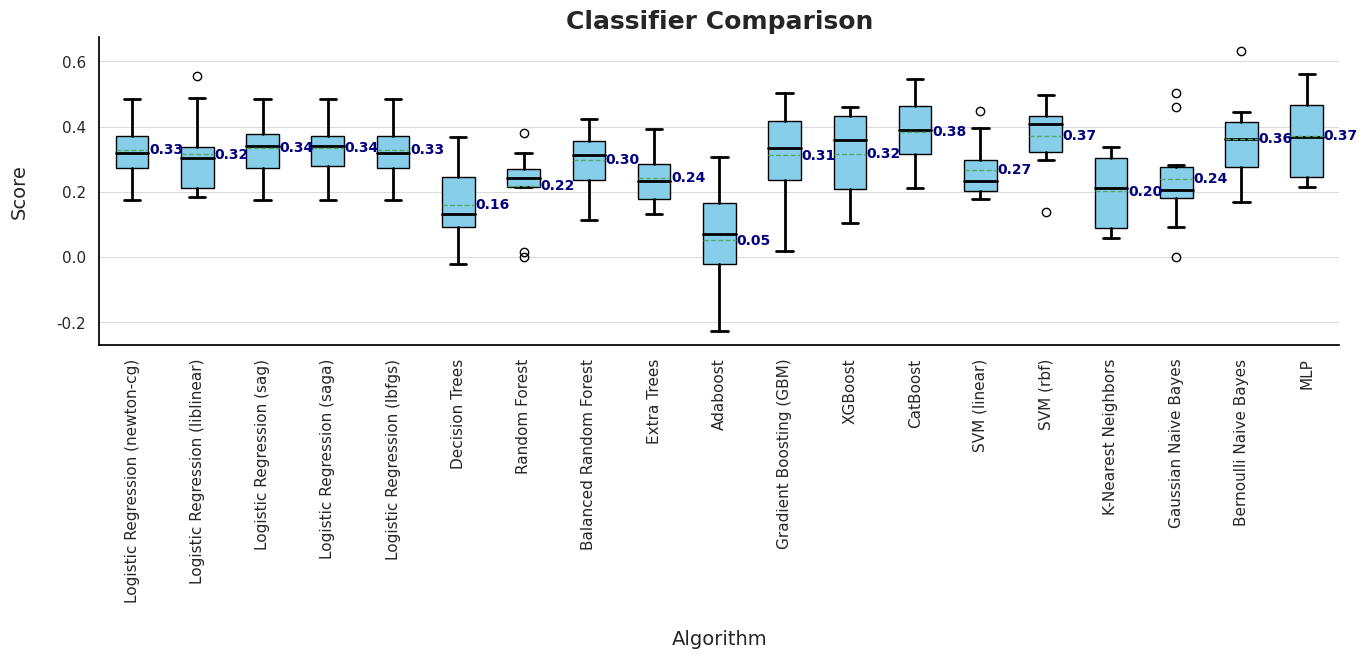

------------------------------------------------------------

Running evaluation for classifier: Logistic Regression (newton-cg)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (newton-cg),0.662841,0.671951,0.747307,0.695368,0.555106,Train
1,Logistic Regression (newton-cg),0.474916,0.312412,0.310634,0.304716,0.252331,Test



Running evaluation for classifier: Logistic Regression (liblinear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (liblinear),0.698709,0.645605,0.739583,0.681844,0.596272,Train
1,Logistic Regression (liblinear),0.521739,0.322274,0.319599,0.318236,0.277212,Test



Running evaluation for classifier: Logistic Regression (sag)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (sag),0.664275,0.673221,0.748651,0.696867,0.555292,Train
1,Logistic Regression (sag),0.474916,0.313377,0.310634,0.305201,0.262148,Test



Running evaluation for classifier: Logistic Regression (saga)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (saga),0.664275,0.672731,0.747920,0.696583,0.557759,Train
1,Logistic Regression (saga),0.474916,0.313377,0.310634,0.305201,0.262148,Test



Running evaluation for classifier: Logistic Regression (lbfgs)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (lbfgs),0.662841,0.671951,0.747307,0.695368,0.555106,Train
1,Logistic Regression (lbfgs),0.474916,0.312412,0.310634,0.304716,0.252331,Test



Running evaluation for classifier: Decision Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Decision Trees,0.837877,0.626755,0.573742,0.593241,0.677878,Train
1,Decision Trees,0.558528,0.329936,0.317493,0.317386,0.198914,Test



Running evaluation for classifier: Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Random Forest,0.581940,0.326960,0.281659,0.264189,0.139814,Test



Running evaluation for classifier: Balanced Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Balanced Random Forest,0.546628,0.437688,0.594862,0.397248,0.333264,Train
1,Balanced Random Forest,0.428094,0.300214,0.401403,0.270533,0.138776,Test



Running evaluation for classifier: Extra Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Extra Trees,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Extra Trees,0.595318,0.359271,0.319201,0.319815,0.223518,Test



Running evaluation for classifier: Adaboost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Adaboost,0.568149,0.583157,0.576376,0.576582,0.297445,Train
1,Adaboost,0.501672,0.267376,0.271139,0.267620,0.166318,Test



Running evaluation for classifier: Gradient Boosting (GBM)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gradient Boosting (GBM),1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Gradient Boosting (GBM),0.568562,0.335703,0.309469,0.311105,0.312444,Test



Running evaluation for classifier: XGBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,XGBoost,0.605351,0.332698,0.317962,0.313384,0.254517,Test



Running evaluation for classifier: CatBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,CatBoost,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,CatBoost,0.591973,0.356877,0.355529,0.355626,0.288393,Test



Running evaluation for classifier: SVM (linear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (linear),0.694405,0.730354,0.782772,0.743142,0.591049,Train
1,SVM (linear),0.481605,0.312824,0.313911,0.309247,0.266406,Test



Running evaluation for classifier: SVM (rbf)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (rbf),0.839311,0.844556,0.898541,0.863570,0.757169,Train
1,SVM (rbf),0.508361,0.323537,0.327036,0.319490,0.350816,Test



Running evaluation for classifier: K-Nearest Neighbors


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,K-Nearest Neighbors,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,K-Nearest Neighbors,0.578595,0.257340,0.282768,0.261364,0.093839,Test



Running evaluation for classifier: Gaussian Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gaussian Naive Bayes,0.555237,0.444399,0.564393,0.365019,0.300622,Train
1,Gaussian Naive Bayes,0.498328,0.333755,0.296418,0.300265,0.149632,Test



Running evaluation for classifier: Bernoulli Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Bernoulli Naive Bayes,0.585366,0.435943,0.595161,0.455173,0.409133,Train
1,Bernoulli Naive Bayes,0.511706,0.349534,0.410805,0.352912,0.217388,Test



Running evaluation for classifier: MLP


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,MLP,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,MLP,0.535117,0.303737,0.301969,0.301617,0.214274,Test


In [48]:
# Perform Cross Validation (with actigraph)
qwk_scorer = make_scorer(custom_qwk, greater_is_better=True)
cv1_results, cv1_names = model_cross_validation_perf(classifiers,X1_train, y1_train, qwk_scorer)
boxplot_cv(cv1_results, cv1_names)
print("------"*10)
cv1_perf = model_perf(classifiers, X1_train, y1_train, X1_val, y1_val)


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean = 0.8164, Std Dev = 0.0197
Logistic Regression (liblinear): Mean = 0.7932, Std Dev = 0.0158
Logistic Regression (sag): Mean = 0.8164, Std Dev = 0.0197
Logistic Regression (saga): Mean = 0.8146, Std Dev = 0.0191
Logistic Regression (lbfgs): Mean = 0.8164, Std Dev = 0.0197
Decision Trees: Mean = 0.7896, Std Dev = 0.0436
Random Forest: Mean = 0.9214, Std Dev = 0.0095
Balanced Random Forest: Mean = 0.9262, Std Dev = 0.0064
Extra Trees: Mean = 0.9337, Std Dev = 0.0199
Adaboost: Mean = 0.7569, Std Dev = 0.0269
Gradient Boosting (GBM): Mean = 0.9210, Std Dev = 0.0105
XGBoost: Mean = 0.9288, Std Dev = 0.0239
CatBoost: Mean = 0.9187, Std Dev = 0.0178
SVM (linear): Mean = 0.8312, Std Dev = 0.0176
SVM (rbf): Mean = 0.9310, Std Dev = 0.0154
K-Nearest Neighbors: Mean = 0.7535, Std Dev = 0.0469
Gaussian Naive Bayes: Mean = 0.7127, Std Dev = 0.0282
Bernoulli Naive Bayes: Mean = 0.7376, Std Dev = 0.0186
MLP: Mean = 0.9304, Std Dev =

,Classifier,Mean Score,Std Deviation
0,Logistic Regression (newton-cg),0.816436,0.019697
1,Logistic Regression (liblinear),0.793180,0.015844
2,Logistic Regression (sag),0.816436,0.019697
3,Logistic Regression (saga),0.814648,0.019057
4,Logistic Regression (lbfgs),0.816436,0.019697
5,Decision Trees,0.789576,0.043579
6,Random Forest,0.921407,0.009510
7,Balanced Random Forest,0.926168,0.006433
8,Extra Trees,0.933658,0.019903
9,Adaboost,0.756937,0.026856


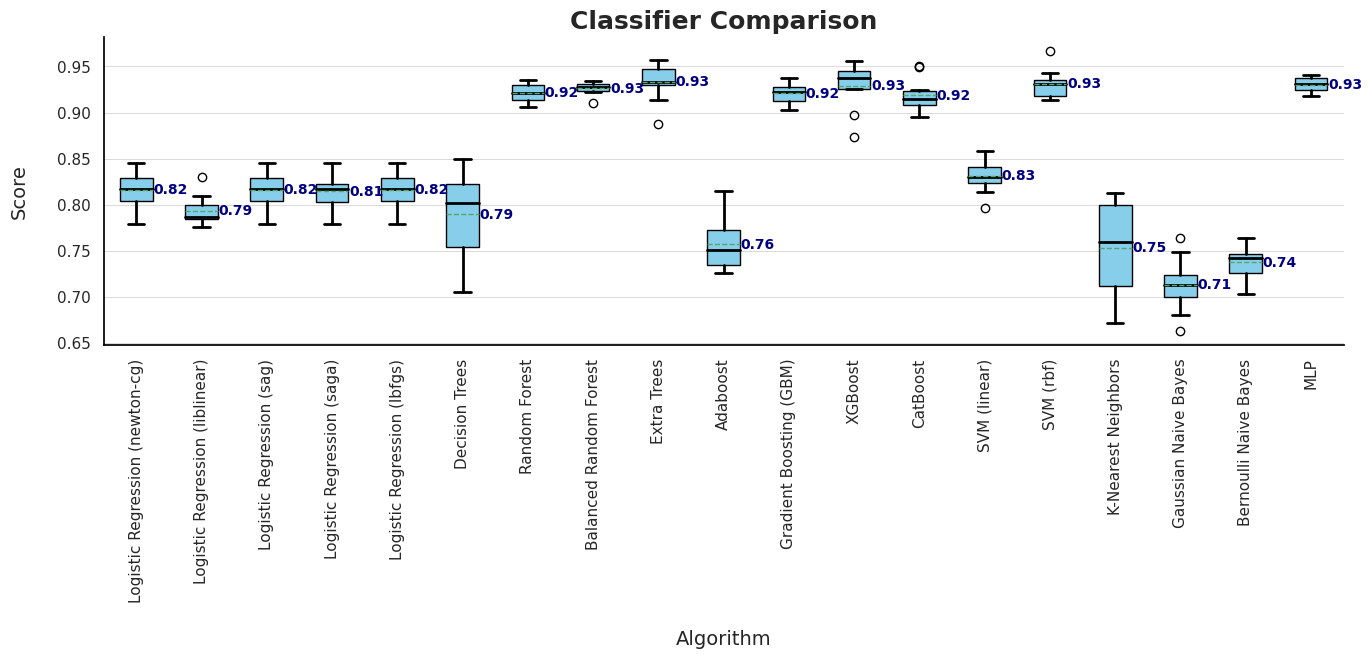

------------------------------------------------------------

Running evaluation for classifier: Logistic Regression (newton-cg)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (newton-cg),0.800000,0.798658,0.799157,0.798047,0.862580,Train
1,Logistic Regression (newton-cg),0.501672,0.334068,0.335213,0.328213,0.257102,Test



Running evaluation for classifier: Logistic Regression (liblinear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (liblinear),0.768519,0.765348,0.767578,0.764969,0.841255,Train
1,Logistic Regression (liblinear),0.484950,0.321207,0.315340,0.313477,0.232375,Test



Running evaluation for classifier: Logistic Regression (sag)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (sag),0.800000,0.798658,0.799157,0.798047,0.862580,Train
1,Logistic Regression (sag),0.498328,0.331294,0.332088,0.325019,0.257984,Test



Running evaluation for classifier: Logistic Regression (saga)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (saga),0.799383,0.798022,0.798535,0.797425,0.862262,Train
1,Logistic Regression (saga),0.498328,0.331294,0.332088,0.325019,0.257984,Test



Running evaluation for classifier: Logistic Regression (lbfgs)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (lbfgs),0.799383,0.798022,0.798535,0.797425,0.862262,Train
1,Logistic Regression (lbfgs),0.501672,0.334068,0.335213,0.328213,0.257102,Test



Running evaluation for classifier: Decision Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Decision Trees,0.904321,0.904703,0.904073,0.904079,0.929518,Train
1,Decision Trees,0.444816,0.277833,0.278245,0.275308,0.061053,Test



Running evaluation for classifier: Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Random Forest,0.598662,0.365653,0.366028,0.365654,0.390223,Test



Running evaluation for classifier: Balanced Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Balanced Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Balanced Random Forest,0.608696,0.379167,0.381348,0.379647,0.357399,Test



Running evaluation for classifier: Extra Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Extra Trees,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Extra Trees,0.581940,0.352841,0.343617,0.344938,0.288496,Test



Running evaluation for classifier: Adaboost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Adaboost,0.642593,0.629554,0.641471,0.614689,0.766964,Train
1,Adaboost,0.515050,0.301020,0.314641,0.288683,0.208364,Test



Running evaluation for classifier: Gradient Boosting (GBM)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gradient Boosting (GBM),1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Gradient Boosting (GBM),0.575251,0.331332,0.326753,0.326171,0.322519,Test



Running evaluation for classifier: XGBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,XGBoost,0.595318,0.366218,0.347635,0.350810,0.304305,Test



Running evaluation for classifier: CatBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,CatBoost,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,CatBoost,0.575251,0.355374,0.353491,0.353235,0.344403,Test



Running evaluation for classifier: SVM (linear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (linear),0.826543,0.825129,0.825743,0.824732,0.877515,Train
1,SVM (linear),0.505017,0.336749,0.341731,0.334056,0.259419,Test



Running evaluation for classifier: SVM (rbf)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (rbf),0.977778,0.977676,0.977630,0.977580,0.982868,Train
1,SVM (rbf),0.581940,0.352865,0.341485,0.343850,0.303305,Test



Running evaluation for classifier: K-Nearest Neighbors


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,K-Nearest Neighbors,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,K-Nearest Neighbors,0.294314,0.281578,0.309450,0.231132,0.114547,Test



Running evaluation for classifier: Gaussian Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gaussian Naive Bayes,0.586420,0.656916,0.586781,0.534158,0.729486,Train
1,Gaussian Naive Bayes,0.448161,0.333150,0.292374,0.269268,0.153448,Test



Running evaluation for classifier: Bernoulli Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Bernoulli Naive Bayes,0.657407,0.651551,0.656323,0.644939,0.748888,Train
1,Bernoulli Naive Bayes,0.478261,0.319736,0.328622,0.310333,0.206956,Test



Running evaluation for classifier: MLP


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,MLP,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,MLP,0.538462,0.315567,0.313155,0.313974,0.213998,Test


In [49]:
# Perform Cross Validation (Resampled with actigraph)
cv1_rs_results, cv1_rs_names = model_cross_validation_perf(classifiers, X1_train_rs, y1_train_rs, qwk_scorer)
boxplot_cv(cv1_rs_results, cv1_rs_names)
print("------"*10)
cv1f_perf = model_perf(classifiers, X1_train_rs, y1_train_rs, X1_val, y1_val)


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean = 0.3350, Std Dev = 0.0471
Logistic Regression (liblinear): Mean = 0.3112, Std Dev = 0.0846
Logistic Regression (sag): Mean = 0.3312, Std Dev = 0.0409
Logistic Regression (saga): Mean = 0.3296, Std Dev = 0.0398
Logistic Regression (lbfgs): Mean = 0.3350, Std Dev = 0.0471
Decision Trees: Mean = 0.1577, Std Dev = 0.1315
Random Forest: Mean = 0.2482, Std Dev = 0.1163
Balanced Random Forest: Mean = 0.2885, Std Dev = 0.0845
Extra Trees: Mean = 0.3489, Std Dev = 0.0990
Adaboost: Mean = 0.1307, Std Dev = 0.2001
Gradient Boosting (GBM): Mean = 0.2993, Std Dev = 0.1410
XGBoost: Mean = 0.3044, Std Dev = 0.0992
CatBoost: Mean = 0.3930, Std Dev = 0.1153
SVM (linear): Mean = 0.3374, Std Dev = 0.0663
SVM (rbf): Mean = 0.3364, Std Dev = 0.1024
K-Nearest Neighbors: Mean = 0.2136, Std Dev = 0.1013
Gaussian Naive Bayes: Mean = 0.2879, Std Dev = 0.1125
Bernoulli Naive Bayes: Mean = 0.3563, Std Dev = 0.0990
MLP: Mean = 0.2533, Std Dev =

,Classifier,Mean Score,Std Deviation
0,Logistic Regression (newton-cg),0.334983,0.047109
1,Logistic Regression (liblinear),0.311248,0.084558
2,Logistic Regression (sag),0.331155,0.040907
3,Logistic Regression (saga),0.329598,0.039844
4,Logistic Regression (lbfgs),0.334983,0.047109
5,Decision Trees,0.157654,0.131470
6,Random Forest,0.248228,0.116330
7,Balanced Random Forest,0.288507,0.084494
8,Extra Trees,0.348857,0.099033
9,Adaboost,0.130658,0.200132


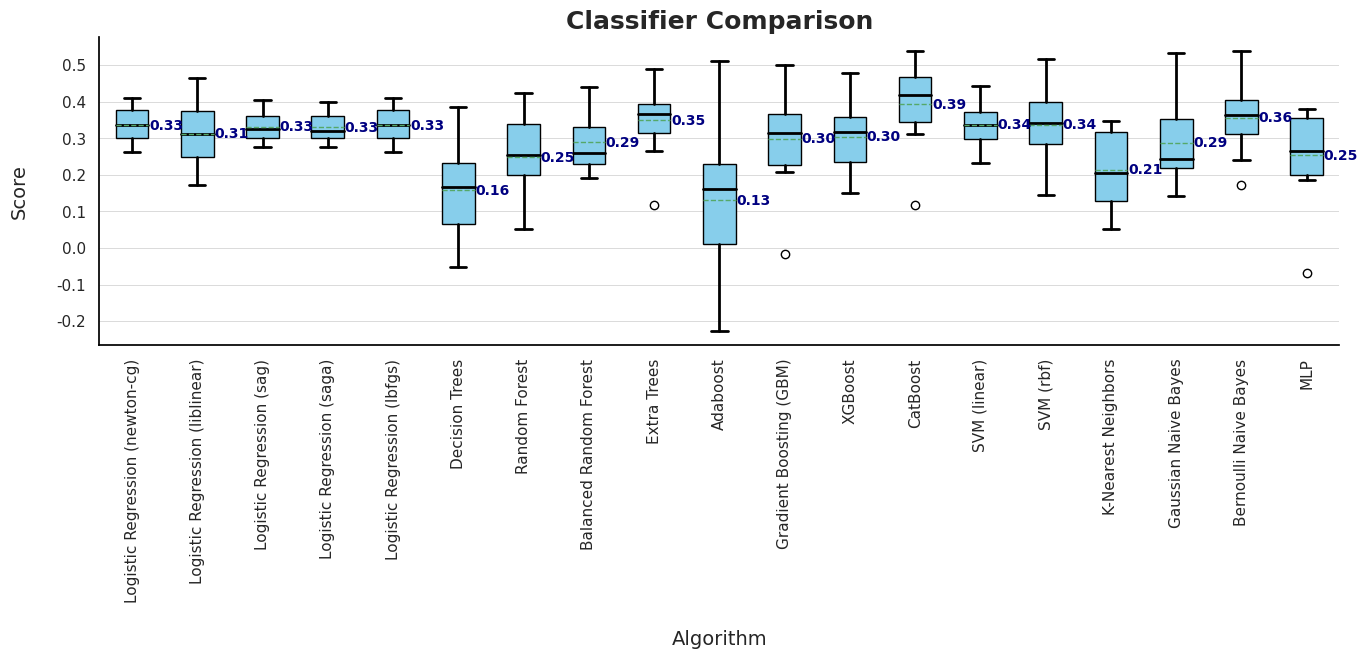

------------------------------------------------------------

Running evaluation for classifier: Logistic Regression (newton-cg)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (newton-cg),0.634146,0.573869,0.708556,0.617283,0.503171,Train
1,Logistic Regression (newton-cg),0.508361,0.353490,0.412334,0.354808,0.248052,Test



Running evaluation for classifier: Logistic Regression (liblinear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (liblinear),0.651363,0.523730,0.671084,0.559785,0.495863,Train
1,Logistic Regression (liblinear),0.568562,0.358532,0.340020,0.346116,0.263220,Test



Running evaluation for classifier: Logistic Regression (sag)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (sag),0.629842,0.543761,0.705986,0.590306,0.487003,Train
1,Logistic Regression (sag),0.508361,0.353282,0.412334,0.354882,0.251573,Test



Running evaluation for classifier: Logistic Regression (saga)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (saga),0.629842,0.543761,0.705986,0.590306,0.487003,Train
1,Logistic Regression (saga),0.508361,0.353490,0.412334,0.354808,0.248052,Test



Running evaluation for classifier: Logistic Regression (lbfgs)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (lbfgs),0.634146,0.573869,0.708556,0.617283,0.503171,Train
1,Logistic Regression (lbfgs),0.508361,0.353490,0.412334,0.354808,0.248052,Test



Running evaluation for classifier: Decision Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Decision Trees,0.833572,0.617632,0.570846,0.587739,0.678814,Train
1,Decision Trees,0.535117,0.305859,0.298576,0.298389,0.139919,Test



Running evaluation for classifier: Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Random Forest,0.585284,0.329197,0.286481,0.270788,0.195365,Test



Running evaluation for classifier: Balanced Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Balanced Random Forest,0.538020,0.442141,0.611628,0.398534,0.333284,Train
1,Balanced Random Forest,0.414716,0.325547,0.421571,0.292413,0.140465,Test



Running evaluation for classifier: Extra Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Extra Trees,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Extra Trees,0.591973,0.339075,0.327951,0.327947,0.293267,Test



Running evaluation for classifier: Adaboost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Adaboost,0.476327,0.570675,0.578777,0.556495,0.218306,Train
1,Adaboost,0.397993,0.278281,0.286274,0.262332,0.091646,Test



Running evaluation for classifier: Gradient Boosting (GBM)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gradient Boosting (GBM),1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Gradient Boosting (GBM),0.555184,0.305207,0.289327,0.285551,0.208228,Test



Running evaluation for classifier: XGBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,XGBoost,0.602007,0.339116,0.317809,0.314543,0.304245,Test



Running evaluation for classifier: CatBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,CatBoost,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,CatBoost,0.555184,0.323129,0.327099,0.323799,0.313787,Test



Running evaluation for classifier: SVM (linear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (linear),0.655667,0.697510,0.739000,0.703774,0.535873,Train
1,SVM (linear),0.471572,0.308155,0.301984,0.297803,0.211368,Test



Running evaluation for classifier: SVM (rbf)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (rbf),0.766141,0.734478,0.848153,0.774120,0.641206,Train
1,SVM (rbf),0.528428,0.337990,0.348338,0.337355,0.329494,Test



Running evaluation for classifier: K-Nearest Neighbors


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,K-Nearest Neighbors,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,K-Nearest Neighbors,0.578595,0.334667,0.305272,0.302051,0.210870,Test



Running evaluation for classifier: Gaussian Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gaussian Naive Bayes,0.558106,0.398002,0.593869,0.408173,0.378185,Train
1,Gaussian Naive Bayes,0.508361,0.344289,0.402155,0.346231,0.228726,Test



Running evaluation for classifier: Bernoulli Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Bernoulli Naive Bayes,0.576758,0.409787,0.545492,0.422458,0.397995,Train
1,Bernoulli Naive Bayes,0.508361,0.347485,0.400038,0.344206,0.197425,Test



Running evaluation for classifier: MLP


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,MLP,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,MLP,0.575251,0.347462,0.346270,0.346382,0.301546,Test


In [50]:
# Perform Cross Validation (with actigraph-selected features)
cv1_rfe_results, cv1_rfe_names = model_cross_validation_perf(classifiers, X1_train_rfe, y1_train, qwk_scorer)
boxplot_cv(cv1_rfe_results, cv1_rfe_names)
print("------"*10)
cv1_resampled_perf = model_perf(classifiers, X1_train_rfe, y1_train, X1_val_rfe, y1_val)


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean = 0.7756, Std Dev = 0.0356
Logistic Regression (liblinear): Mean = 0.7390, Std Dev = 0.0388
Logistic Regression (sag): Mean = 0.7751, Std Dev = 0.0354
Logistic Regression (saga): Mean = 0.7754, Std Dev = 0.0345
Logistic Regression (lbfgs): Mean = 0.7756, Std Dev = 0.0356
Decision Trees: Mean = 0.8021, Std Dev = 0.0391
Random Forest: Mean = 0.9103, Std Dev = 0.0133
Balanced Random Forest: Mean = 0.9123, Std Dev = 0.0178
Extra Trees: Mean = 0.9146, Std Dev = 0.0134
Adaboost: Mean = 0.7453, Std Dev = 0.0275
Gradient Boosting (GBM): Mean = 0.9203, Std Dev = 0.0217
XGBoost: Mean = 0.9277, Std Dev = 0.0168
CatBoost: Mean = 0.9127, Std Dev = 0.0200
SVM (linear): Mean = 0.8167, Std Dev = 0.0288
SVM (rbf): Mean = 0.8842, Std Dev = 0.0200
K-Nearest Neighbors: Mean = 0.7688, Std Dev = 0.0315
Gaussian Naive Bayes: Mean = 0.7082, Std Dev = 0.0286
Bernoulli Naive Bayes: Mean = 0.7113, Std Dev = 0.0141
MLP: Mean = 0.9173, Std Dev =

,Classifier,Mean Score,Std Deviation
0,Logistic Regression (newton-cg),0.775553,0.035639
1,Logistic Regression (liblinear),0.738960,0.038804
2,Logistic Regression (sag),0.775068,0.035446
3,Logistic Regression (saga),0.775377,0.034456
4,Logistic Regression (lbfgs),0.775553,0.035639
5,Decision Trees,0.802069,0.039069
6,Random Forest,0.910342,0.013306
7,Balanced Random Forest,0.912309,0.017837
8,Extra Trees,0.914650,0.013380
9,Adaboost,0.745318,0.027522


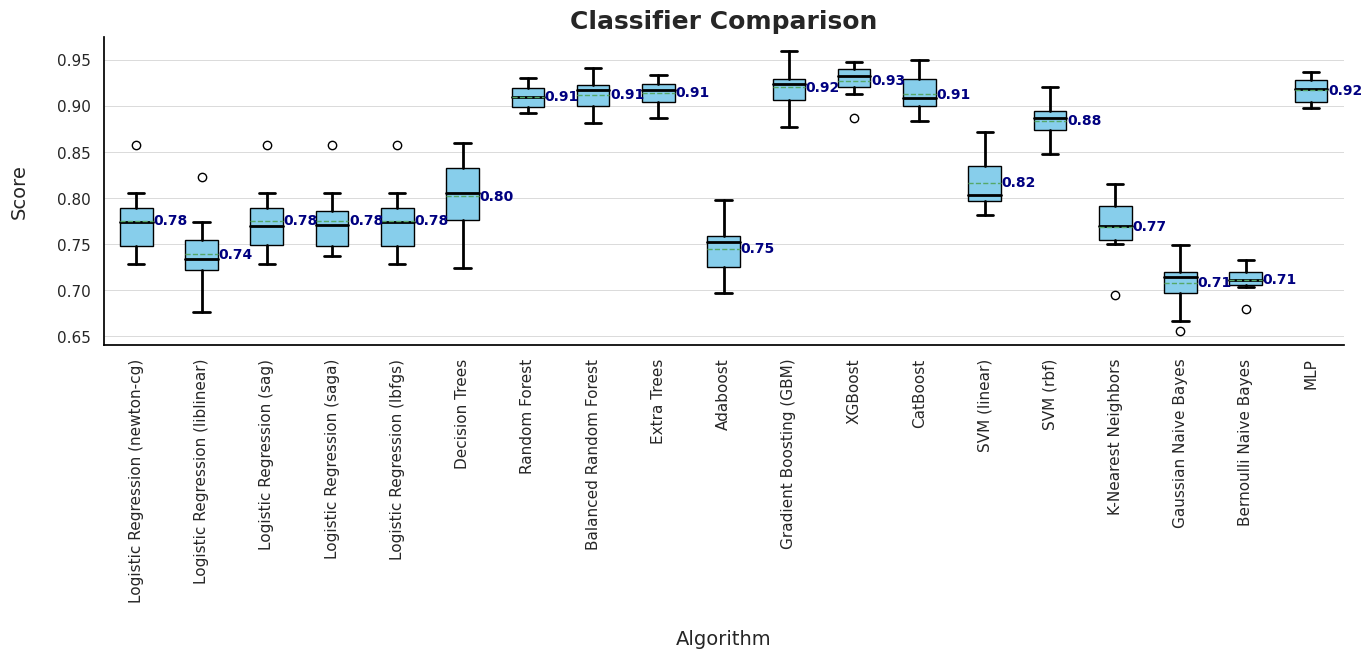

------------------------------------------------------------

Running evaluation for classifier: Logistic Regression (newton-cg)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (newton-cg),0.741975,0.739078,0.741028,0.738993,0.819014,Train
1,Logistic Regression (newton-cg),0.525084,0.368435,0.426262,0.368396,0.241977,Test



Running evaluation for classifier: Logistic Regression (liblinear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (liblinear),0.712963,0.705632,0.712120,0.707019,0.786407,Train
1,Logistic Regression (liblinear),0.538462,0.384225,0.439618,0.380716,0.220903,Test



Running evaluation for classifier: Logistic Regression (sag)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (sag),0.741358,0.738390,0.740406,0.738311,0.818858,Train
1,Logistic Regression (sag),0.525084,0.368435,0.426262,0.368396,0.241977,Test



Running evaluation for classifier: Logistic Regression (saga)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (saga),0.741358,0.738474,0.740416,0.738403,0.818120,Train
1,Logistic Regression (saga),0.525084,0.368435,0.426262,0.368396,0.241977,Test



Running evaluation for classifier: Logistic Regression (lbfgs)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (lbfgs),0.741975,0.739078,0.741028,0.738993,0.819014,Train
1,Logistic Regression (lbfgs),0.525084,0.368435,0.426262,0.368396,0.241977,Test



Running evaluation for classifier: Decision Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Decision Trees,0.903086,0.903179,0.902820,0.902783,0.931476,Train
1,Decision Trees,0.458194,0.291548,0.293717,0.289483,0.079798,Test



Running evaluation for classifier: Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Random Forest,0.575251,0.346841,0.351359,0.348648,0.313396,Test



Running evaluation for classifier: Balanced Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Balanced Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Balanced Random Forest,0.575251,0.354224,0.361973,0.356983,0.333013,Test



Running evaluation for classifier: Extra Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Extra Trees,0.999383,0.999389,0.999378,0.999383,0.999012,Train
1,Extra Trees,0.568562,0.347222,0.358275,0.349489,0.346063,Test



Running evaluation for classifier: Adaboost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Adaboost,0.604938,0.610218,0.604423,0.585811,0.753595,Train
1,Adaboost,0.508361,0.270325,0.270603,0.266037,0.120737,Test



Running evaluation for classifier: Gradient Boosting (GBM)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gradient Boosting (GBM),1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Gradient Boosting (GBM),0.578595,0.340468,0.333691,0.335232,0.276625,Test



Running evaluation for classifier: XGBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,XGBoost,0.585284,0.349082,0.338680,0.339995,0.313578,Test



Running evaluation for classifier: CatBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,CatBoost,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,CatBoost,0.588629,0.361323,0.363018,0.361352,0.322279,Test



Running evaluation for classifier: SVM (linear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (linear),0.779012,0.777574,0.777994,0.776073,0.845035,Train
1,SVM (linear),0.488294,0.321165,0.320161,0.312449,0.283757,Test



Running evaluation for classifier: SVM (rbf)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (rbf),0.933951,0.933703,0.933577,0.933233,0.951465,Train
1,SVM (rbf),0.565217,0.343606,0.347929,0.345447,0.317751,Test



Running evaluation for classifier: K-Nearest Neighbors


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,K-Nearest Neighbors,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,K-Nearest Neighbors,0.327759,0.294081,0.267308,0.238672,0.156152,Test



Running evaluation for classifier: Gaussian Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gaussian Naive Bayes,0.612346,0.609672,0.611456,0.606722,0.723458,Train
1,Gaussian Naive Bayes,0.418060,0.318157,0.316463,0.293717,0.187462,Test



Running evaluation for classifier: Bernoulli Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Bernoulli Naive Bayes,0.615432,0.597398,0.614391,0.594085,0.719266,Train
1,Bernoulli Naive Bayes,0.478261,0.323586,0.317587,0.306964,0.186506,Test



Running evaluation for classifier: MLP


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,MLP,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,MLP,0.555184,0.330965,0.331753,0.331119,0.276783,Test


In [51]:
# Perform Cross Validation (Resampled with actigraph-selected features)
cv1f_results, cv1f_names = model_cross_validation_perf(classifiers, X1_train_rs_rfe, y1_train_rs, qwk_scorer)
boxplot_cv(cv1f_results, cv1f_names)
print("------"*10)
cv1f_perf = model_perf(classifiers, X1_train_rs_rfe, y1_train_rs, X1_val_rfe, y1_val)

In [52]:
# Define the base models
base_models = [
    ("Balanced Random Forest", BalancedRandomForestClassifier(class_weight="balanced", n_estimators=300, max_depth=10, random_state=42)),    
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", n_estimators=300, depth=6, learning_rate=0.1, silent=True, random_state=42)),
    ("Extra Trees", ExtraTreesClassifier(class_weight="balanced", n_estimators=300, max_depth=10, random_state=42)),
    ("XGBoost", XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, colsample_bytree=0.8, subsample=0.8, random_state=42, eval_metric="mlogloss"))
]

# Define meta-model
meta_model = LogisticRegression(solver="lbfgs", class_weight="balanced", random_state=42, max_iter=1000)

# Create the stacking classifier
stacking_classifier = [
    ("Stacking Classifier", StackingClassifier(
        estimators=base_models, 
        final_estimator=meta_model,
        cv=5
    ))
]
# Train the stacking model
best1_stack_perf = model_perf(stacking_classifier, X1_train_rs_rfe, y1_train_rs, X1_val_rfe, y1_val)


Running evaluation for classifier: Stacking Classifier


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Stacking Classifier,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Stacking Classifier,0.612040,0.367937,0.350109,0.351862,0.373819,Test


In [53]:
voting_classifier = [
    ("Voting Classifier", VotingClassifier(
        estimators=base_models,
        voting="soft", 
        n_jobs=-1))
]

# Train the voting model
best1_voting_perf = model_perf(voting_classifier, X1_train_rs_rfe, y1_train_rs, X1_val_rfe, y1_val)


Running evaluation for classifier: Voting Classifier


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Voting Classifier,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Voting Classifier,0.581940,0.346669,0.347010,0.345757,0.357302,Test


In [54]:
# Prepare the test_act dataset
X1_test = test_act.drop(columns=['sii', 'Actigraphy Available'])

# Scale the test_act data using the same scaler fitted on training data
X1_test_s = scaler.transform(X1_test.drop(columns=['id']))
X1_test_scaled = pd.DataFrame(X1_test_s, columns=X1_test.drop(columns=['id']).columns, index=X1_test.index)

# Predict using stacking_classifier
stacking_clf_model = stacking_classifier[0][1]  # Access the actual StackingClassifier object
stacking_clf_model.fit(X1_train_rs, y1_train_rs)
test_act['sii_predicted_stacking'] = stacking_clf_model.predict(X1_test_scaled)

# Predict using voting_classifier
voting_clf_model = voting_classifier[0][1]  # Assuming voting_classifier is already defined as a VotingClassifier
voting_clf_model.fit(X1_train_rs, y1_train_rs)
test_act['sii_predicted_voting'] = voting_clf_model.predict(X1_test_scaled)

# Displaying the ID to predicted mappings for both classifiers
id_sii_mapping = test_act[['id', 'sii_predicted_stacking', 'sii_predicted_voting']]
id_sii_mapping

,id,sii_predicted_stacking,sii_predicted_voting
0,00115b9f,0.000000,0.000000
1,001f3379,1.000000,1.000000


In [55]:
# Split based on Actigraphy availability
actigraphy_yes = train_encoded[train_encoded['Actigraphy Available'] == 1].drop(columns=['id', 'Total Rows', 'wear_rate', 'Actigraphy Available'])
actigraphy_no = train_encoded[train_encoded['Actigraphy Available'] == 0].drop(columns=['Total Rows', 'wear_rate', 'Actigraphy Available'])

In [56]:
actigraphy_no_sii_no = actigraphy_no[actigraphy_no['sii'].isna()]
actigraphy_no_sii = actigraphy_no[~actigraphy_no['sii'].isna()]

# Define predictor features and target
X = actigraphy_no_sii.drop(columns=['id', 'sii'])
y = actigraphy_no_sii['sii']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Initialize scaler
scaler = StandardScaler() 

# Fit scaler on training data and transform
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

X_train = pd.DataFrame(X_train_s, columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(X_val_s, columns=X_val.columns, index=X_val.index)

In [57]:
X_train_rs, y_train_rs = smote_tomek.fit_resample(X_train, y_train)
X_train_rs = pd.DataFrame(X_train_rs, columns=X_train.columns)

# Check class distribution after SMOTETomek
class_distribution = Counter(y_train_rs)
print("Class distribution after SMOTETomek:")
for label, count in class_distribution.items():
    print(f"Class {label}: {count} samples")

Class distribution after SMOTETomek:
Class 0.0: 740 samples
Class 1.0: 741 samples
Class 2.0: 757 samples
Class 3.0: 758 samples


In [58]:
rf_model = RandomForestClassifier(
    n_estimators=350,          
    max_depth=12,              
    min_samples_split=6,       
    min_samples_leaf=2,        
    max_features='sqrt',       
    class_weight='balanced',   
    random_state=42,           
    n_jobs=-1                  
)

qwk_scorer = make_scorer(custom_qwk, greater_is_better=True)

# Initialize the RFECV selector
selector = RFECV(estimator=rf_model, step=1, cv=5, scoring=qwk_scorer, n_jobs=-1) 
X_selected = selector.fit_transform(X_train, y_train)
X_selected_features = X.columns[selector.support_]
print(f"No. of selected features: {len(X_selected_features)}\n")
print(f"Selected features:\n{X_selected_features.tolist()}")

No. of selected features: 27

Selected features:
['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_TL', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw', 'PreInt_EduHx-computerinternet_hoursday', 'Basic_Demos-Enroll_Season_Summer', 'CGAS-Season_Spring', 'FGC-Season_Spring', 'SDS-Season_Summer', 'SDS-Season_Winter', 'PreInt_EduHx-Season_Spring']


In [59]:
X_train_rfe = X_train[X_selected_features]
X_val_rfe = X_val[X_selected_features]
X_train_rs_rfe = X_train_rs[X_selected_features]


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean = 0.3558, Std Dev = 0.0859
Logistic Regression (liblinear): Mean = 0.3787, Std Dev = 0.0928
Logistic Regression (sag): Mean = 0.3607, Std Dev = 0.0890
Logistic Regression (saga): Mean = 0.3685, Std Dev = 0.0949
Logistic Regression (lbfgs): Mean = 0.3566, Std Dev = 0.0849
Decision Trees: Mean = 0.3183, Std Dev = 0.0734
Random Forest: Mean = 0.3304, Std Dev = 0.1068
Balanced Random Forest: Mean = 0.3395, Std Dev = 0.0566
Extra Trees: Mean = 0.3414, Std Dev = 0.1122
Adaboost: Mean = 0.2516, Std Dev = 0.0708
Gradient Boosting (GBM): Mean = 0.3402, Std Dev = 0.0878
XGBoost: Mean = 0.3066, Std Dev = 0.0888
CatBoost: Mean = 0.4208, Std Dev = 0.0716
SVM (linear): Mean = 0.3828, Std Dev = 0.0786
SVM (rbf): Mean = 0.3841, Std Dev = 0.0633
K-Nearest Neighbors: Mean = 0.1350, Std Dev = 0.0510
Gaussian Naive Bayes: Mean = 0.2633, Std Dev = 0.0883
Bernoulli Naive Bayes: Mean = 0.2921, Std Dev = 0.0833
MLP: Mean = 0.2924, Std Dev =

,Classifier,Mean Score,Std Deviation
0,Logistic Regression (newton-cg),0.355847,0.085898
1,Logistic Regression (liblinear),0.378660,0.092773
2,Logistic Regression (sag),0.360686,0.089036
3,Logistic Regression (saga),0.368505,0.094856
4,Logistic Regression (lbfgs),0.356602,0.084893
5,Decision Trees,0.318308,0.073398
6,Random Forest,0.330429,0.106784
7,Balanced Random Forest,0.339505,0.056642
8,Extra Trees,0.341371,0.112209
9,Adaboost,0.251558,0.070751


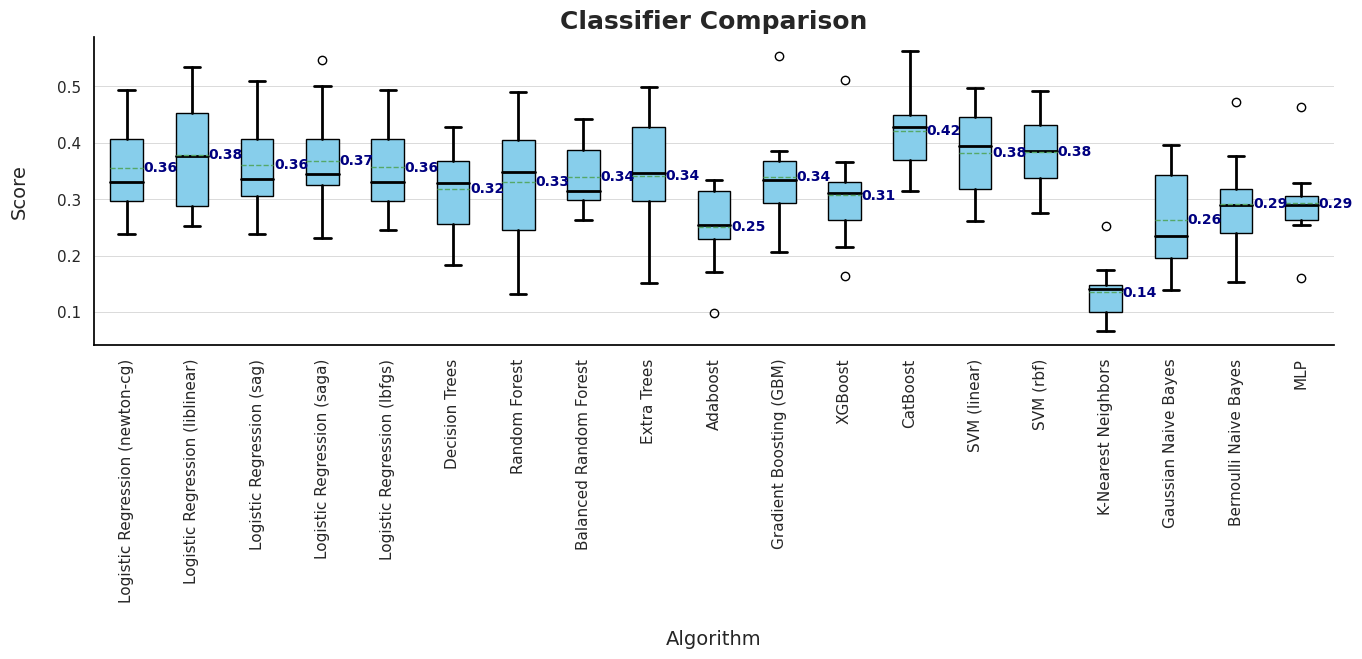

--------------------------------------------------------------------------------------------------------------

Running evaluation for classifier: Logistic Regression (newton-cg)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (newton-cg),0.595402,0.482900,0.663001,0.520121,0.456027,Train
1,Logistic Regression (newton-cg),0.503448,0.354317,0.417747,0.362251,0.387919,Test



Running evaluation for classifier: Logistic Regression (liblinear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (liblinear),0.615326,0.473219,0.619344,0.495170,0.474495,Train
1,Logistic Regression (liblinear),0.535632,0.339444,0.395649,0.346184,0.395494,Test



Running evaluation for classifier: Logistic Regression (sag)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (sag),0.591571,0.471782,0.656758,0.506731,0.454310,Train
1,Logistic Regression (sag),0.496552,0.347842,0.410437,0.354224,0.375800,Test



Running evaluation for classifier: Logistic Regression (saga)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (saga),0.588506,0.467210,0.654662,0.501783,0.451911,Train
1,Logistic Regression (saga),0.498851,0.350461,0.414603,0.358210,0.372218,Test



Running evaluation for classifier: Logistic Regression (lbfgs)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (lbfgs),0.596169,0.483673,0.663720,0.520990,0.456030,Train
1,Logistic Regression (lbfgs),0.503448,0.354317,0.417747,0.362251,0.387919,Test



Running evaluation for classifier: Decision Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Decision Trees,0.803831,0.775404,0.606862,0.648257,0.650938,Train
1,Decision Trees,0.542529,0.441989,0.349367,0.371423,0.295665,Test



Running evaluation for classifier: Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Random Forest,0.959387,0.971646,0.965263,0.967563,0.946009,Train
1,Random Forest,0.595402,0.372367,0.357366,0.358867,0.378905,Test



Running evaluation for classifier: Balanced Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Balanced Random Forest,0.560920,0.443020,0.638331,0.431252,0.387749,Train
1,Balanced Random Forest,0.457471,0.306932,0.464894,0.296872,0.363015,Test



Running evaluation for classifier: Extra Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Extra Trees,0.980843,0.986927,0.983983,0.985234,0.978524,Train
1,Extra Trees,0.556322,0.320619,0.314817,0.314077,0.353232,Test



Running evaluation for classifier: Adaboost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Adaboost,0.592337,0.563729,0.564681,0.553504,0.391316,Train
1,Adaboost,0.526437,0.387808,0.361076,0.358750,0.276361,Test



Running evaluation for classifier: Gradient Boosting (GBM)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gradient Boosting (GBM),1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Gradient Boosting (GBM),0.551724,0.340240,0.331067,0.332384,0.294166,Test



Running evaluation for classifier: XGBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,XGBoost,0.577011,0.480960,0.375091,0.399138,0.346188,Test



Running evaluation for classifier: CatBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,CatBoost,0.937931,0.898128,0.964736,0.927943,0.886569,Train
1,CatBoost,0.549425,0.486524,0.479877,0.479081,0.439915,Test



Running evaluation for classifier: SVM (linear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (linear),0.616858,0.624967,0.693402,0.645699,0.503870,Train
1,SVM (linear),0.524138,0.385335,0.430464,0.395583,0.383263,Test



Running evaluation for classifier: SVM (rbf)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (rbf),0.740996,0.723621,0.817917,0.758526,0.657354,Train
1,SVM (rbf),0.531034,0.461733,0.398784,0.405130,0.371175,Test



Running evaluation for classifier: K-Nearest Neighbors


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,K-Nearest Neighbors,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,K-Nearest Neighbors,0.581609,0.371306,0.290078,0.278954,0.185657,Test



Running evaluation for classifier: Gaussian Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gaussian Naive Bayes,0.553257,0.392270,0.482692,0.363103,0.311920,Train
1,Gaussian Naive Bayes,0.544828,0.324556,0.450265,0.332061,0.379372,Test



Running evaluation for classifier: Bernoulli Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Bernoulli Naive Bayes,0.542529,0.379854,0.512135,0.376733,0.313804,Train
1,Bernoulli Naive Bayes,0.519540,0.327036,0.408006,0.322039,0.281092,Test



Running evaluation for classifier: MLP


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,MLP,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,MLP,0.540230,0.455822,0.370951,0.392253,0.338853,Test


In [60]:
# Perform Cross Validation (without actigraph)
qwk_scorer = make_scorer(custom_qwk, greater_is_better=True)
cv_results, cv_names = model_cross_validation_perf(classifiers, X_train, y_train, qwk_scorer)
boxplot_cv(cv_results, cv_names)
print("-----------"*10)
cv_no_perf = model_perf(classifiers, X_train, y_train, X_val, y_val)


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean = 0.7676, Std Dev = 0.0256
Logistic Regression (liblinear): Mean = 0.7380, Std Dev = 0.0278
Logistic Regression (sag): Mean = 0.7659, Std Dev = 0.0272
Logistic Regression (saga): Mean = 0.7643, Std Dev = 0.0268
Logistic Regression (lbfgs): Mean = 0.7676, Std Dev = 0.0256
Decision Trees: Mean = 0.7844, Std Dev = 0.0314
Random Forest: Mean = 0.8984, Std Dev = 0.0216
Balanced Random Forest: Mean = 0.8964, Std Dev = 0.0267
Extra Trees: Mean = 0.8999, Std Dev = 0.0220
Adaboost: Mean = 0.7957, Std Dev = 0.0212
Gradient Boosting (GBM): Mean = 0.9107, Std Dev = 0.0186
XGBoost: Mean = 0.9132, Std Dev = 0.0221
CatBoost: Mean = 0.8973, Std Dev = 0.0245
SVM (linear): Mean = 0.7921, Std Dev = 0.0221
SVM (rbf): Mean = 0.8959, Std Dev = 0.0222
K-Nearest Neighbors: Mean = 0.7711, Std Dev = 0.0244
Gaussian Naive Bayes: Mean = 0.6804, Std Dev = 0.0245
Bernoulli Naive Bayes: Mean = 0.6249, Std Dev = 0.0275
MLP: Mean = 0.9177, Std Dev =

,Classifier,Mean Score,Std Deviation
0,Logistic Regression (newton-cg),0.767559,0.025553
1,Logistic Regression (liblinear),0.738034,0.027750
2,Logistic Regression (sag),0.765901,0.027225
3,Logistic Regression (saga),0.764270,0.026803
4,Logistic Regression (lbfgs),0.767559,0.025553
5,Decision Trees,0.784400,0.031423
6,Random Forest,0.898436,0.021605
7,Balanced Random Forest,0.896357,0.026734
8,Extra Trees,0.899894,0.021998
9,Adaboost,0.795689,0.021241


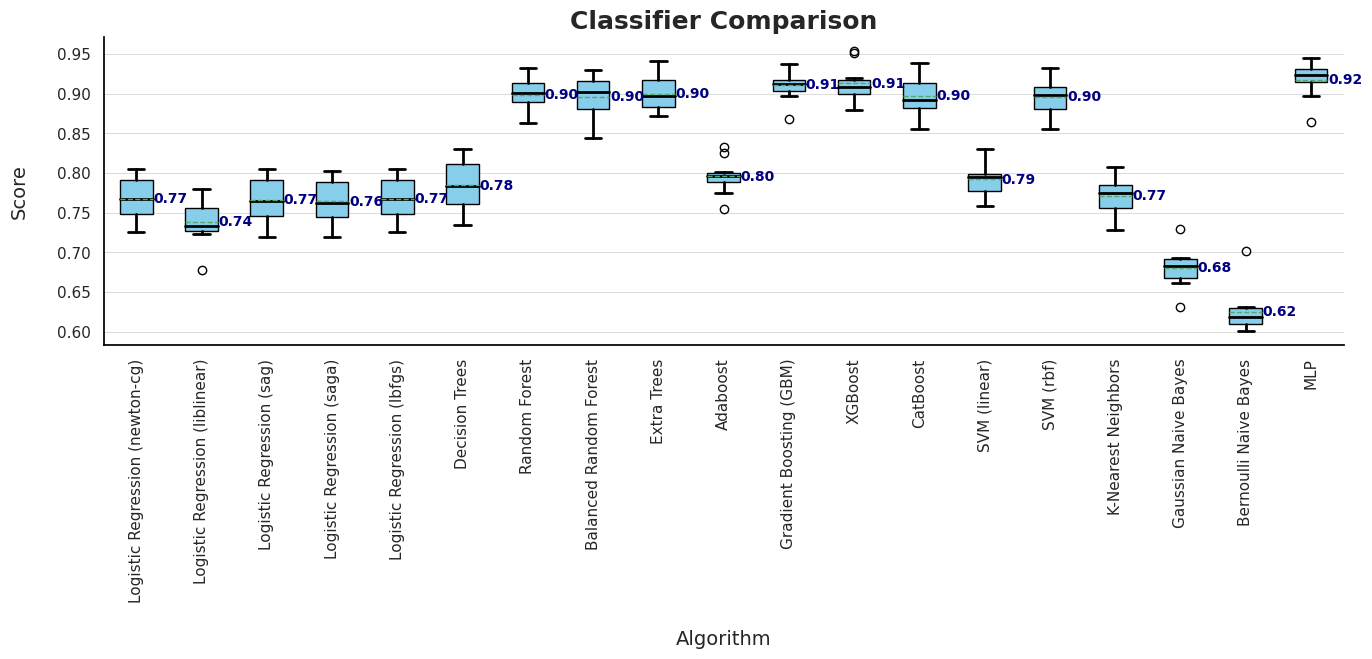

--------------------------------------------------------------------------------------------------------------

Running evaluation for classifier: Logistic Regression (newton-cg)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (newton-cg),0.691589,0.679568,0.689923,0.681428,0.788059,Train
1,Logistic Regression (newton-cg),0.526437,0.371842,0.437486,0.380213,0.408047,Test



Running evaluation for classifier: Logistic Regression (liblinear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (liblinear),0.673565,0.657201,0.671927,0.657591,0.766615,Train
1,Logistic Regression (liblinear),0.524138,0.357824,0.417949,0.361024,0.387346,Test



Running evaluation for classifier: Logistic Regression (sag)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (sag),0.689920,0.677496,0.688271,0.679592,0.785494,Train
1,Logistic Regression (sag),0.526437,0.371892,0.437486,0.380466,0.410882,Test



Running evaluation for classifier: Logistic Regression (saga)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (saga),0.688585,0.675655,0.686958,0.678105,0.783709,Train
1,Logistic Regression (saga),0.526437,0.370267,0.434308,0.377322,0.413244,Test



Running evaluation for classifier: Logistic Regression (lbfgs)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (lbfgs),0.691589,0.679568,0.689923,0.681428,0.788059,Train
1,Logistic Regression (lbfgs),0.526437,0.371842,0.437486,0.380213,0.408047,Test



Running evaluation for classifier: Decision Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Decision Trees,0.884179,0.883773,0.883672,0.883699,0.907786,Train
1,Decision Trees,0.452874,0.303464,0.320365,0.306111,0.271648,Test



Running evaluation for classifier: Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Random Forest,0.988652,0.988742,0.988546,0.988570,0.990292,Train
1,Random Forest,0.551724,0.446890,0.414436,0.424988,0.396113,Test



Running evaluation for classifier: Balanced Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Balanced Random Forest,0.985981,0.986121,0.985876,0.985894,0.989646,Train
1,Balanced Random Forest,0.540230,0.414330,0.407161,0.408473,0.395034,Test



Running evaluation for classifier: Extra Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Extra Trees,0.983645,0.983868,0.983514,0.983534,0.988723,Train
1,Extra Trees,0.549425,0.412679,0.400411,0.403655,0.359769,Test



Running evaluation for classifier: Adaboost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Adaboost,0.681575,0.671168,0.679977,0.662137,0.806645,Train
1,Adaboost,0.579310,0.467471,0.429795,0.439507,0.382560,Test



Running evaluation for classifier: Gradient Boosting (GBM)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gradient Boosting (GBM),1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Gradient Boosting (GBM),0.554023,0.592579,0.376880,0.408938,0.337191,Test



Running evaluation for classifier: XGBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,XGBoost,0.554023,0.423612,0.403554,0.409712,0.356990,Test



Running evaluation for classifier: CatBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,CatBoost,0.979640,0.979570,0.979481,0.979489,0.984294,Train
1,CatBoost,0.528736,0.432510,0.477220,0.451137,0.395810,Test



Running evaluation for classifier: SVM (linear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (linear),0.723965,0.719859,0.722467,0.719255,0.815711,Train
1,SVM (linear),0.528736,0.389116,0.441131,0.401797,0.397828,Test



Running evaluation for classifier: SVM (rbf)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (rbf),0.924900,0.924390,0.924305,0.924013,0.955842,Train
1,SVM (rbf),0.540230,0.414876,0.373807,0.387029,0.319354,Test



Running evaluation for classifier: K-Nearest Neighbors


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,K-Nearest Neighbors,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,K-Nearest Neighbors,0.337931,0.311129,0.395970,0.280232,0.214437,Test



Running evaluation for classifier: Gaussian Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gaussian Naive Bayes,0.548398,0.578377,0.548699,0.520380,0.682080,Train
1,Gaussian Naive Bayes,0.443678,0.327549,0.429159,0.305888,0.301730,Test



Running evaluation for classifier: Bernoulli Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Bernoulli Naive Bayes,0.539720,0.514238,0.538739,0.508230,0.626470,Train
1,Bernoulli Naive Bayes,0.498851,0.322224,0.405469,0.317453,0.299683,Test



Running evaluation for classifier: MLP


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,MLP,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,MLP,0.512644,0.373421,0.385569,0.379009,0.324202,Test


In [61]:
# Perform Cross Validation (Resampled without actigraph)
cv_rs_results, cv_rs_names = model_cross_validation_perf(classifiers, X_train_rs, y_train_rs, qwk_scorer)
boxplot_cv(cv_rs_results, cv_rs_names)
print("-----------"*10)
cv_no_rs_perf = model_perf(classifiers, X_train_rs, y_train_rs, X_val, y_val)


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean = 0.3776, Std Dev = 0.0632
Logistic Regression (liblinear): Mean = 0.3895, Std Dev = 0.0846
Logistic Regression (sag): Mean = 0.3780, Std Dev = 0.0634
Logistic Regression (saga): Mean = 0.3787, Std Dev = 0.0607
Logistic Regression (lbfgs): Mean = 0.3776, Std Dev = 0.0632
Decision Trees: Mean = 0.3012, Std Dev = 0.0584
Random Forest: Mean = 0.3926, Std Dev = 0.0736
Balanced Random Forest: Mean = 0.3554, Std Dev = 0.0545
Extra Trees: Mean = 0.3939, Std Dev = 0.0896
Adaboost: Mean = 0.2260, Std Dev = 0.0877
Gradient Boosting (GBM): Mean = 0.3473, Std Dev = 0.0391
XGBoost: Mean = 0.3595, Std Dev = 0.0833
CatBoost: Mean = 0.4245, Std Dev = 0.0650
SVM (linear): Mean = 0.4013, Std Dev = 0.0660
SVM (rbf): Mean = 0.3922, Std Dev = 0.0710
K-Nearest Neighbors: Mean = 0.2565, Std Dev = 0.0448
Gaussian Naive Bayes: Mean = 0.2975, Std Dev = 0.0863
Bernoulli Naive Bayes: Mean = 0.3263, Std Dev = 0.0739
MLP: Mean = 0.2736, Std Dev =

,Classifier,Mean Score,Std Deviation
0,Logistic Regression (newton-cg),0.377584,0.063221
1,Logistic Regression (liblinear),0.389520,0.084577
2,Logistic Regression (sag),0.378048,0.063385
3,Logistic Regression (saga),0.378744,0.060706
4,Logistic Regression (lbfgs),0.377584,0.063221
5,Decision Trees,0.301158,0.058385
6,Random Forest,0.392554,0.073597
7,Balanced Random Forest,0.355412,0.054508
8,Extra Trees,0.393880,0.089648
9,Adaboost,0.225984,0.087733


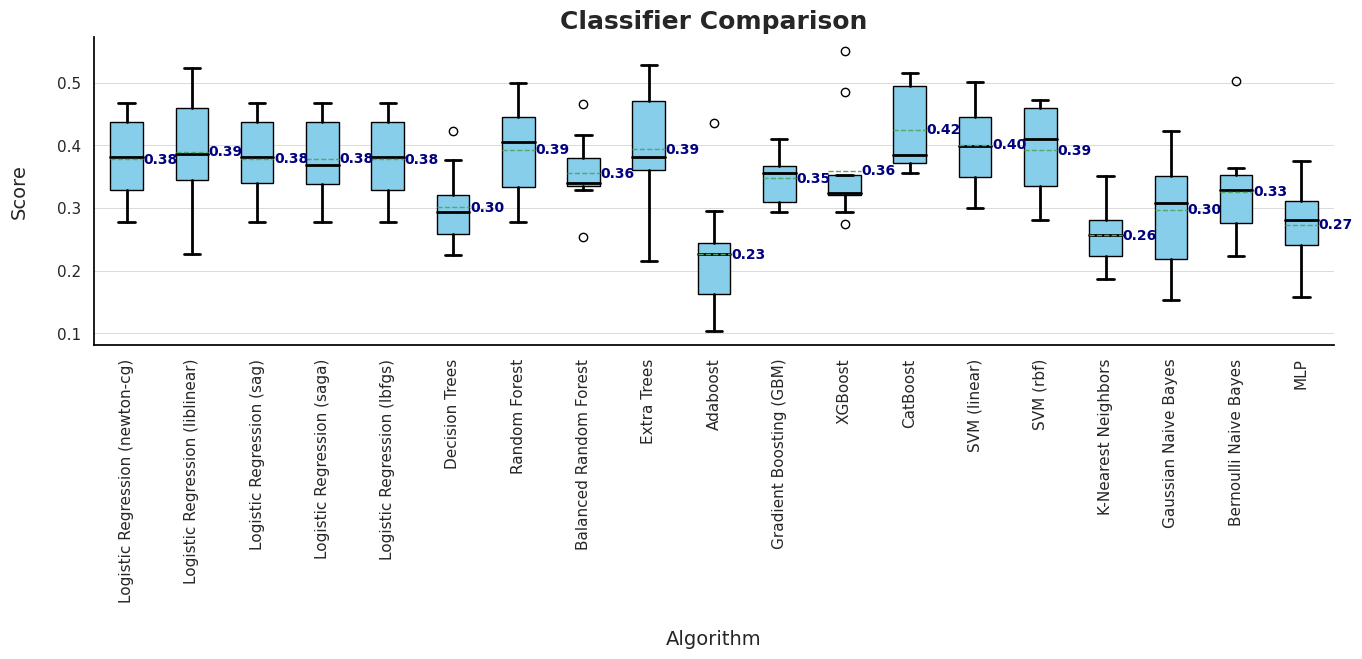

--------------------------------------------------------------------------------------------------------------

Running evaluation for classifier: Logistic Regression (newton-cg)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (newton-cg),0.563218,0.420054,0.609556,0.440659,0.428182,Train
1,Logistic Regression (newton-cg),0.501149,0.341776,0.428508,0.344345,0.403341,Test



Running evaluation for classifier: Logistic Regression (liblinear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (liblinear),0.600000,0.436844,0.589931,0.444889,0.439542,Train
1,Logistic Regression (liblinear),0.540230,0.333599,0.425789,0.337237,0.391604,Test



Running evaluation for classifier: Logistic Regression (sag)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (sag),0.563218,0.420054,0.609556,0.440659,0.428182,Train
1,Logistic Regression (sag),0.501149,0.341776,0.428508,0.344345,0.403341,Test



Running evaluation for classifier: Logistic Regression (saga)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (saga),0.563985,0.420754,0.610937,0.440676,0.431954,Train
1,Logistic Regression (saga),0.501149,0.341776,0.428508,0.344345,0.403341,Test



Running evaluation for classifier: Logistic Regression (lbfgs)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (lbfgs),0.563218,0.420054,0.609556,0.440659,0.428182,Train
1,Logistic Regression (lbfgs),0.501149,0.341776,0.428508,0.344345,0.403341,Test



Running evaluation for classifier: Decision Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Decision Trees,0.801533,0.723603,0.626842,0.662999,0.658221,Train
1,Decision Trees,0.528736,0.392200,0.343960,0.358870,0.275196,Test



Running evaluation for classifier: Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Random Forest,0.957088,0.970274,0.964159,0.966211,0.946077,Train
1,Random Forest,0.595402,0.617217,0.442224,0.484128,0.398519,Test



Running evaluation for classifier: Balanced Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Balanced Random Forest,0.565517,0.438780,0.626665,0.434119,0.410216,Train
1,Balanced Random Forest,0.466667,0.325210,0.434325,0.310258,0.352735,Test



Running evaluation for classifier: Extra Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Extra Trees,0.967050,0.963429,0.972172,0.967337,0.950917,Train
1,Extra Trees,0.581609,0.477031,0.440641,0.453056,0.439763,Test



Running evaluation for classifier: Adaboost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Adaboost,0.606130,0.571735,0.561200,0.552360,0.407789,Train
1,Adaboost,0.558621,0.486623,0.404041,0.421752,0.283018,Test



Running evaluation for classifier: Gradient Boosting (GBM)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gradient Boosting (GBM),1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Gradient Boosting (GBM),0.581609,0.360578,0.350915,0.352122,0.304247,Test



Running evaluation for classifier: XGBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,XGBoost,0.579310,0.445636,0.405733,0.414211,0.339443,Test



Running evaluation for classifier: CatBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,CatBoost,0.920307,0.877215,0.952099,0.910317,0.868258,Train
1,CatBoost,0.556322,0.472433,0.485498,0.477183,0.403991,Test



Running evaluation for classifier: SVM (linear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (linear),0.590805,0.464429,0.652383,0.501386,0.475008,Train
1,SVM (linear),0.519540,0.368261,0.457496,0.387010,0.396089,Test



Running evaluation for classifier: SVM (rbf)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (rbf),0.721073,0.690733,0.798713,0.731431,0.630039,Train
1,SVM (rbf),0.528736,0.441863,0.479675,0.455123,0.446075,Test



Running evaluation for classifier: K-Nearest Neighbors


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,K-Nearest Neighbors,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,K-Nearest Neighbors,0.593103,0.357776,0.311234,0.307248,0.241852,Test



Running evaluation for classifier: Gaussian Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gaussian Naive Bayes,0.557854,0.352354,0.473425,0.347217,0.334171,Train
1,Gaussian Naive Bayes,0.554023,0.378361,0.450071,0.338070,0.383397,Test



Running evaluation for classifier: Bernoulli Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Bernoulli Naive Bayes,0.537931,0.365220,0.488391,0.361232,0.339217,Train
1,Bernoulli Naive Bayes,0.528736,0.355155,0.422338,0.338128,0.308413,Test



Running evaluation for classifier: MLP


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,MLP,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,MLP,0.535632,0.421459,0.402974,0.410908,0.306587,Test


In [62]:
# Perform Cross Validation (without actigraph-selected features)
cv_rfe_results, cv_rfe_names = model_cross_validation_perf(classifiers, X_train_rfe, y_train, qwk_scorer)
boxplot_cv(cv_rfe_results, cv_rfe_names)
print("-----------"*10)
cv_no_rfe_perf = model_perf(classifiers, X_train_rfe, y_train, X_val_rfe, y_val)


Cross-Validation Performance:

Logistic Regression (newton-cg): Mean = 0.7382, Std Dev = 0.0293
Logistic Regression (liblinear): Mean = 0.7217, Std Dev = 0.0205
Logistic Regression (sag): Mean = 0.7379, Std Dev = 0.0291
Logistic Regression (saga): Mean = 0.7385, Std Dev = 0.0290
Logistic Regression (lbfgs): Mean = 0.7384, Std Dev = 0.0291
Decision Trees: Mean = 0.7763, Std Dev = 0.0311
Random Forest: Mean = 0.8857, Std Dev = 0.0224
Balanced Random Forest: Mean = 0.8839, Std Dev = 0.0251
Extra Trees: Mean = 0.8826, Std Dev = 0.0220
Adaboost: Mean = 0.7915, Std Dev = 0.0210
Gradient Boosting (GBM): Mean = 0.8973, Std Dev = 0.0254
XGBoost: Mean = 0.9138, Std Dev = 0.0218
CatBoost: Mean = 0.8909, Std Dev = 0.0228
SVM (linear): Mean = 0.7656, Std Dev = 0.0268
SVM (rbf): Mean = 0.8618, Std Dev = 0.0266
K-Nearest Neighbors: Mean = 0.7858, Std Dev = 0.0346
Gaussian Naive Bayes: Mean = 0.6643, Std Dev = 0.0271
Bernoulli Naive Bayes: Mean = 0.6262, Std Dev = 0.0271
MLP: Mean = 0.9113, Std Dev =

,Classifier,Mean Score,Std Deviation
0,Logistic Regression (newton-cg),0.738171,0.029252
1,Logistic Regression (liblinear),0.721730,0.020472
2,Logistic Regression (sag),0.737926,0.029056
3,Logistic Regression (saga),0.738547,0.028973
4,Logistic Regression (lbfgs),0.738375,0.029086
5,Decision Trees,0.776343,0.031073
6,Random Forest,0.885705,0.022372
7,Balanced Random Forest,0.883873,0.025094
8,Extra Trees,0.882588,0.021958
9,Adaboost,0.791549,0.021008


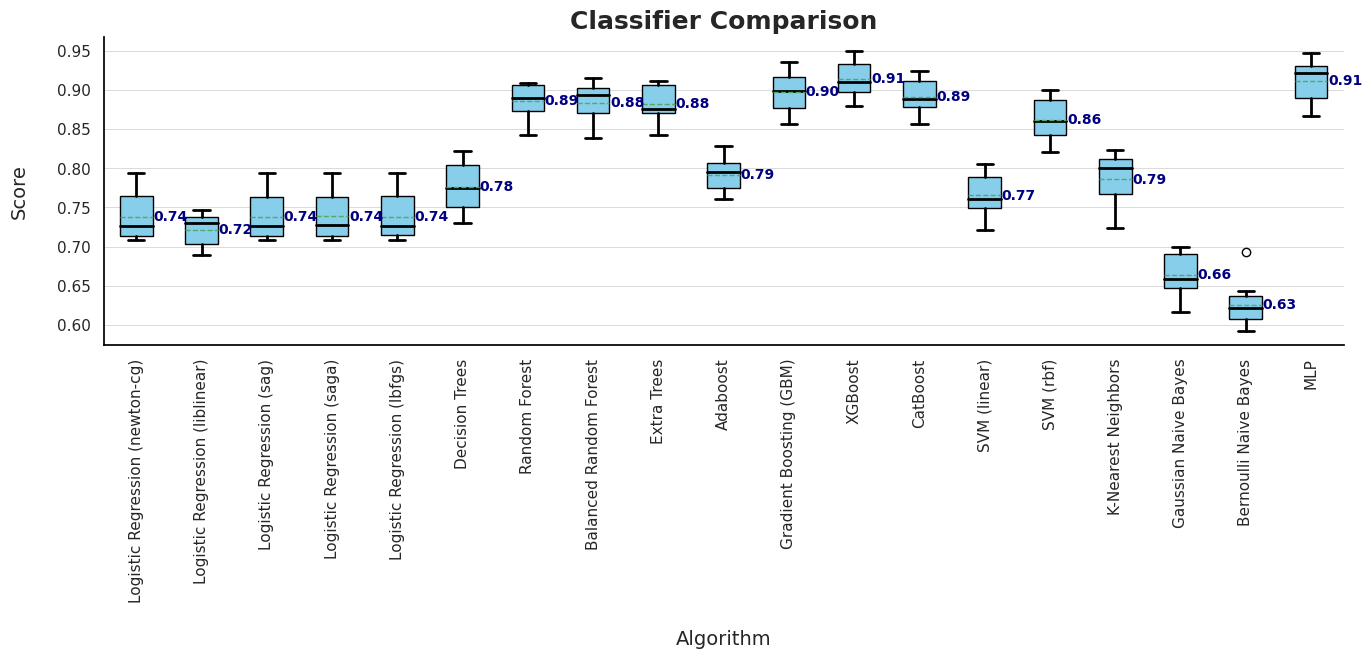

--------------------------------------------------------------------------------------------------------------

Running evaluation for classifier: Logistic Regression (newton-cg)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (newton-cg),0.643525,0.624158,0.642069,0.627933,0.749888,Train
1,Logistic Regression (newton-cg),0.510345,0.357513,0.451532,0.364241,0.402550,Test



Running evaluation for classifier: Logistic Regression (liblinear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (liblinear),0.628838,0.606032,0.627285,0.606414,0.734733,Train
1,Logistic Regression (liblinear),0.494253,0.336817,0.428077,0.336512,0.374730,Test



Running evaluation for classifier: Logistic Regression (sag)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (sag),0.643858,0.624581,0.642406,0.628350,0.749950,Train
1,Logistic Regression (sag),0.510345,0.357513,0.451532,0.364241,0.402550,Test



Running evaluation for classifier: Logistic Regression (saga)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (saga),0.643858,0.624691,0.642406,0.628357,0.748882,Train
1,Logistic Regression (saga),0.510345,0.357365,0.451532,0.363954,0.399928,Test



Running evaluation for classifier: Logistic Regression (lbfgs)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Logistic Regression (lbfgs),0.643858,0.624581,0.642406,0.628350,0.749950,Train
1,Logistic Regression (lbfgs),0.510345,0.357513,0.451532,0.364241,0.402550,Test



Running evaluation for classifier: Decision Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Decision Trees,0.881175,0.881337,0.880746,0.880833,0.909577,Train
1,Decision Trees,0.491954,0.324030,0.341509,0.329516,0.302575,Test



Running evaluation for classifier: Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Random Forest,0.980307,0.980441,0.980129,0.980156,0.981794,Train
1,Random Forest,0.560920,0.427187,0.508437,0.454368,0.431898,Test



Running evaluation for classifier: Balanced Random Forest


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Balanced Random Forest,0.979640,0.979728,0.979446,0.979459,0.981922,Train
1,Balanced Random Forest,0.558621,0.431319,0.510105,0.457917,0.408177,Test



Running evaluation for classifier: Extra Trees


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Extra Trees,0.969960,0.970657,0.969742,0.969752,0.977068,Train
1,Extra Trees,0.542529,0.371340,0.486005,0.397349,0.420514,Test



Running evaluation for classifier: Adaboost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Adaboost,0.665220,0.658861,0.664145,0.659564,0.814835,Train
1,Adaboost,0.556322,0.416238,0.435929,0.424495,0.350343,Test



Running evaluation for classifier: Gradient Boosting (GBM)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gradient Boosting (GBM),1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Gradient Boosting (GBM),0.544828,0.413451,0.395579,0.402147,0.368736,Test



Running evaluation for classifier: XGBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,XGBoost,0.567816,0.416863,0.454185,0.425748,0.371922,Test



Running evaluation for classifier: CatBoost


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,CatBoost,0.970961,0.970927,0.970743,0.970721,0.979153,Train
1,CatBoost,0.563218,0.484272,0.514937,0.496971,0.436067,Test



Running evaluation for classifier: SVM (linear)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (linear),0.677570,0.663459,0.676072,0.665057,0.784037,Train
1,SVM (linear),0.533333,0.385572,0.476784,0.403016,0.400703,Test



Running evaluation for classifier: SVM (rbf)


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,SVM (rbf),0.874166,0.872879,0.873322,0.872765,0.918157,Train
1,SVM (rbf),0.542529,0.383554,0.421509,0.396492,0.393056,Test



Running evaluation for classifier: K-Nearest Neighbors


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,K-Nearest Neighbors,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,K-Nearest Neighbors,0.434483,0.347799,0.472116,0.347112,0.331708,Test



Running evaluation for classifier: Gaussian Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Gaussian Naive Bayes,0.519359,0.524397,0.520256,0.467321,0.668549,Train
1,Gaussian Naive Bayes,0.473563,0.357429,0.441161,0.313848,0.334320,Test



Running evaluation for classifier: Bernoulli Naive Bayes


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Bernoulli Naive Bayes,0.518358,0.487745,0.517455,0.480210,0.627006,Train
1,Bernoulli Naive Bayes,0.478161,0.293502,0.383739,0.285444,0.291591,Test



Running evaluation for classifier: MLP


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,MLP,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,MLP,0.531034,0.378819,0.426628,0.395776,0.351161,Test


In [63]:
# Perform Cross Validation (Resampled with actigraph-selected features)
cvf_results, cvf_names = model_cross_validation_perf(classifiers, X_train_rs_rfe, y_train_rs, qwk_scorer)
boxplot_cv(cvf_results, cvf_names)
print("-----------"*10)
cv_no_rs_rfe_perf = model_perf(classifiers, X_train_rs_rfe, y_train_rs, X_val_rfe, y_val)

In [64]:
# Define the base models
base2_models = [
    ("Random Forest", RandomForestClassifier(class_weight="balanced", n_estimators=300, max_depth=10, random_state=42)),
    ("Balanced Random Forest", BalancedRandomForestClassifier(class_weight="balanced", n_estimators=300, max_depth=10, random_state=42)),    
    ("Extra Trees", ExtraTreesClassifier(class_weight="balanced", n_estimators=300, max_depth=10, random_state=42)),
    ("SVM (rbf)", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42, gamma="scale")),
    ("CatBoost", CatBoostClassifier(auto_class_weights="Balanced", n_estimators=300, depth=6, learning_rate=0.1, silent=True, random_state=42)),
]

# Create the stacking classifier
stacking2_classifier = [
    ("Stacking Classifier", StackingClassifier(
        estimators=base2_models,  # Use the base classifiers as defined
        final_estimator=LogisticRegression(solver="saga", class_weight="balanced", random_state=42, max_iter=1000),
        cv=5
    ))
]
# Train the stacking model
best2_stack_perf = model_perf(stacking_classifier, X_train_rs_rfe, y_train_rs, X_val_rfe, y_val)


Running evaluation for classifier: Stacking Classifier


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Stacking Classifier,1.000000,1.000000,1.000000,1.000000,1.000000,Train
1,Stacking Classifier,0.570115,0.536483,0.462175,0.489423,0.378615,Test


In [65]:
voting2_classifier = [
    ("Voting Classifier", VotingClassifier(
        estimators=base2_models,
        voting="soft",  
        n_jobs=-1))
]

# Train the voting model
best2_voting_perf = model_perf(voting_classifier, X_train_rs_rfe, y_train_rs, X_val_rfe, y_val)


Running evaluation for classifier: Voting Classifier


,Classifier,Accuracy,Precision,Recall,F1,QWK,Dataset
0,Voting Classifier,0.997997,0.997989,0.997983,0.997979,0.998800,Train
1,Voting Classifier,0.583908,0.462401,0.513973,0.477942,0.422248,Test


In [66]:
# Scale the test_act data using the same scaler fitted on training data
ids = actigraphy_no_sii_no['id'] 
X_test_s = scaler.transform(actigraphy_no_sii_no.drop(columns=['id', 'sii']))
X_test_scaled = pd.DataFrame(X_test_s, columns=actigraphy_no_sii_no.drop(columns=['id', 'sii']).columns, index=actigraphy_no_sii_no.index)
X_test = X_test_scaled[X_selected_features]

# Predict using stacking_classifier
stacking_clf_model = stacking2_classifier[0][1]  
stacking_clf_model.fit(X_train_rs_rfe, y_train_rs)
actigraphy_no_sii_no['sii_predicted_stacking'] = stacking_clf_model.predict(X_test)

# Predict using voting_classifier
voting_clf_model = voting2_classifier[0][1]  
voting_clf_model.fit(X_train_rs_rfe, y_train_rs)
actigraphy_no_sii_no['sii_predicted_voting'] = voting_clf_model.predict(X_test)

# Displaying the ID to predicted mappings for both classifiers
id_sii_mapping2 = actigraphy_no_sii_no[['id', 'sii_predicted_stacking', 'sii_predicted_voting']]
id_sii_mapping2.head(10)

,id,sii_predicted_stacking,sii_predicted_voting
4,0016bb22,2.000000,2.000000
7,0068a485,0.000000,0.000000
8,0069fbed,2.000000,2.000000
9,0083e397,1.000000,1.000000
10,0087dd65,2.000000,2.000000
13,00af6387,1.000000,1.000000
14,00bd4359,2.000000,2.000000
17,00d9913d,0.000000,0.000000
19,00ebc35d,1.000000,1.000000
29,0194c251,1.000000,2.000000


In [67]:
# Scale the test_act data using the same scaler fitted on training data
X_test_s = scaler.transform(test_no_act.drop(columns=['id', 'sii', 'Actigraphy Available', 'Total Rows', 'wear_rate']))
X_test_scaled = pd.DataFrame(X_test_s, columns=test_no_act.drop(columns=['id', 'sii', 'Actigraphy Available', 'Total Rows', 'wear_rate']).columns, index=test_no_act.index)
X_test = X_test_scaled[X_selected_features]

# Predict using stacking_classifier
stacking_clf_model = stacking2_classifier[0][1]  
stacking_clf_model.fit(X_train_rs_rfe, y_train_rs)
test_no_act['sii_predicted_stacking'] = stacking_clf_model.predict(X_test)

# Predict using voting_classifier
voting_clf_model = voting2_classifier[0][1]  
voting_clf_model.fit(X_train_rs_rfe, y_train_rs)
test_no_act['sii_predicted_voting'] = voting_clf_model.predict(X_test)

# Displaying the ID to predicted mappings for both classifiers
id_sii_mapping2 = test_no_act[['id', 'sii_predicted_stacking', 'sii_predicted_voting']]
id_sii_mapping2

,id,sii_predicted_stacking,sii_predicted_voting
0,00008ff9,2.000000,2.000000
1,000fd460,0.000000,0.000000
2,00105258,1.000000,1.000000
4,0016bb22,2.000000,2.000000
6,0038ba98,0.000000,0.000000
7,0068a485,0.000000,0.000000
8,0069fbed,2.000000,2.000000
9,0083e397,1.000000,1.000000
10,0087dd65,2.000000,2.000000
11,00abe655,0.000000,0.000000


In [68]:
# Merge the two results together
merged_mapping = pd.concat([id_sii_mapping2, id_sii_mapping], ignore_index=True)
merged_mapping

,id,sii_predicted_stacking,sii_predicted_voting
0,00008ff9,2.000000,2.000000
1,000fd460,0.000000,0.000000
2,00105258,1.000000,1.000000
3,0016bb22,2.000000,2.000000
4,0038ba98,0.000000,0.000000
5,0068a485,0.000000,0.000000
6,0069fbed,2.000000,2.000000
7,0083e397,1.000000,1.000000
8,0087dd65,2.000000,2.000000
9,00abe655,0.000000,0.000000


In [69]:
# Final predictions
final_predictions = merged_mapping[['id', 'sii_predicted_stacking']].rename(columns={'sii_predicted_stacking': 'sii'})

# Convert the predictions to the required format
final_predictions['sii'] = final_predictions['sii'].astype(int)

# Save the predictions to a CSV file
final_predictions.to_csv("submission.csv", index=False)